In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [2]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [3]:
data_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
data_table = list(data_table)
data_table[0].keys()

dict_keys(['yang_assignments_repeat_1', 'mds_key', 'linguists_sugested_text', 'toloka_text', '_other', 'check_in_yang_results', 'toloka_assignments_repeat_5_with_chorus_and_pitch', 'toloka_assignments_repeat_9_selected_workers_with_chorus_and_pitch', 'date', 'number_of_speakers', 'toloka_assignments_repeat_4_with_bend', 'text', 'raw_text_linguists', 'linguists_comment', 'toloka_assignments_repeat_3_with_pitch', 'toloka_number_of_speakers', 'toloka_assignments_repeat_6_with_chorus', 'toloka_assignments_repeat_1', 'toloka_assignments_repeat_7_with_chorus_and_pitch', 'toloka_assignments_repeat_8_selected_workers_with_chorus_and_pitch', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'toloka_assignments_repeat_11_selected_workers_with_pitch', 'toloka_assignments', 'toloka_assignments_repeat_10', 'toloka_assignments_repeat_2_with_pitch', 'audio', 'url'])

In [4]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [5]:
Context = collections.namedtuple('Context', 'max_num_answers for_fitting platform')
context = Context(7, True, 'toloka')
context

Context(max_num_answers=7, for_fitting=True, platform='toloka')

In [6]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [7]:
def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])
    
    
    text, text_rate = max(texts.items(), key=lambda x: (x[1], x[0] != ""))
    if text != "" and text_rate >= 2:
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    common = speechs.most_common(2)
    speech, speech_rate = common[0]
    if speech == "BAD" and len(common) >= 2 and common[1][1] == speech_rate:
        speech = common[1][0]

    # conf = text_rate / sum(texts.values())
    return AggregationResult(text, conf, cost)

In [8]:
def evaluate_metrics(data, field, algorithm, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = algorithm(sorted(row[field], key=lambda x: x["submit_ts"]))
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost

In [9]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)

In [10]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [11]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [12]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, max_cost=10, cluster_refernces=None, print_=True, add_threshold=0.0):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.cost != max_cost and hyp.confidence < treshhold + add_threshold) or hyp.confidence < treshhold:
            continue
        hyp = hyp.text
        aggregated += 1
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost

In [13]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if text == "":
                    conf = 0
                    text = None
                elif score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [14]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          add_threshold=0.0):
    aggregation_results = aggregate_rover_with_clf_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, 
                                      aggregation_results, 
                                      treshhold, 
                                      max_cost, 
                                      cluster_refernces, 
                                      print_, 
                                      add_threshold)

In [15]:
prod_agg_metrics = evaluate_metrics(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod) 

Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833


In [16]:
import matplotlib.pyplot as plt

In [17]:
train_rows_q = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows_q = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows_q:
    if 'text' in row:
        del row['text']

In [18]:
train_proc_q = Processor(train_rows_q, context)
test_proc_q = Processor(test_rows_q, context)

for row in train_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},
            'text': row['text']}
    train_proc_q.rows.append(value)

for row in test_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},}
    test_proc_q.rows.append(value)

In [19]:
train_features_q = train_proc_q.extract_features()

In [20]:
test_features_q = test_proc_q.extract_features()

In [21]:
X_train_q, Y_train_q = convert_to_array(train_features_q)

In [22]:
clf_q = CatBoostClassifier(iterations=19000, depth=7, thread_count=30, random_seed=42)
clf_q.fit(X_train_q, Y_train_q)
with open("log_assistant.txt", "a") as log:
    log.write("7 overlap model is fitted\n")

Learning rate set to 0.005942
0:	learn: 0.6850859	total: 113ms	remaining: 35m 41s
1:	learn: 0.6771675	total: 174ms	remaining: 27m 29s
2:	learn: 0.6694256	total: 232ms	remaining: 24m 30s
3:	learn: 0.6619567	total: 294ms	remaining: 23m 17s
4:	learn: 0.6544960	total: 354ms	remaining: 22m 24s
5:	learn: 0.6471147	total: 412ms	remaining: 21m 44s
6:	learn: 0.6400100	total: 474ms	remaining: 21m 26s
7:	learn: 0.6329183	total: 536ms	remaining: 21m 13s
8:	learn: 0.6258789	total: 598ms	remaining: 21m 2s
9:	learn: 0.6190780	total: 657ms	remaining: 20m 47s
10:	learn: 0.6125470	total: 721ms	remaining: 20m 44s
11:	learn: 0.6057750	total: 786ms	remaining: 20m 43s
12:	learn: 0.5992511	total: 850ms	remaining: 20m 40s
13:	learn: 0.5927960	total: 912ms	remaining: 20m 36s
14:	learn: 0.5864882	total: 976ms	remaining: 20m 35s
15:	learn: 0.5804050	total: 1.04s	remaining: 20m 39s
16:	learn: 0.5742406	total: 1.11s	remaining: 20m 35s
17:	learn: 0.5683126	total: 1.19s	remaining: 20m 50s
18:	learn: 0.5624242	total:

157:	learn: 0.2542641	total: 10.8s	remaining: 21m 31s
158:	learn: 0.2537112	total: 10.9s	remaining: 21m 30s
159:	learn: 0.2531080	total: 11s	remaining: 21m 30s
160:	learn: 0.2524924	total: 11s	remaining: 21m 29s
161:	learn: 0.2519058	total: 11.1s	remaining: 21m 30s
162:	learn: 0.2513799	total: 11.2s	remaining: 21m 33s
163:	learn: 0.2508899	total: 11.3s	remaining: 21m 33s
164:	learn: 0.2502589	total: 11.3s	remaining: 21m 32s
165:	learn: 0.2497310	total: 11.4s	remaining: 21m 31s
166:	learn: 0.2492211	total: 11.5s	remaining: 21m 31s
167:	learn: 0.2487302	total: 11.5s	remaining: 21m 32s
168:	learn: 0.2481679	total: 11.6s	remaining: 21m 32s
169:	learn: 0.2476157	total: 11.7s	remaining: 21m 33s
170:	learn: 0.2470329	total: 11.7s	remaining: 21m 32s
171:	learn: 0.2464950	total: 11.8s	remaining: 21m 31s
172:	learn: 0.2459893	total: 11.9s	remaining: 21m 30s
173:	learn: 0.2454649	total: 11.9s	remaining: 21m 29s
174:	learn: 0.2449919	total: 12s	remaining: 21m 29s
175:	learn: 0.2445276	total: 12s	r

314:	learn: 0.2115868	total: 20.8s	remaining: 20m 36s
315:	learn: 0.2114829	total: 20.9s	remaining: 20m 35s
316:	learn: 0.2113653	total: 21s	remaining: 20m 35s
317:	learn: 0.2112585	total: 21s	remaining: 20m 35s
318:	learn: 0.2111590	total: 21.1s	remaining: 20m 34s
319:	learn: 0.2110581	total: 21.1s	remaining: 20m 34s
320:	learn: 0.2109691	total: 21.2s	remaining: 20m 33s
321:	learn: 0.2108663	total: 21.3s	remaining: 20m 33s
322:	learn: 0.2107480	total: 21.3s	remaining: 20m 32s
323:	learn: 0.2105910	total: 21.4s	remaining: 20m 32s
324:	learn: 0.2105082	total: 21.4s	remaining: 20m 32s
325:	learn: 0.2103996	total: 21.5s	remaining: 20m 31s
326:	learn: 0.2103135	total: 21.6s	remaining: 20m 31s
327:	learn: 0.2102010	total: 21.6s	remaining: 20m 31s
328:	learn: 0.2101115	total: 21.7s	remaining: 20m 31s
329:	learn: 0.2100203	total: 21.8s	remaining: 20m 31s
330:	learn: 0.2099377	total: 21.8s	remaining: 20m 30s
331:	learn: 0.2098220	total: 21.9s	remaining: 20m 30s
332:	learn: 0.2097378	total: 21.

468:	learn: 0.2011723	total: 30.6s	remaining: 20m 7s
469:	learn: 0.2011240	total: 30.6s	remaining: 20m 7s
470:	learn: 0.2010745	total: 30.7s	remaining: 20m 7s
471:	learn: 0.2010301	total: 30.8s	remaining: 20m 7s
472:	learn: 0.2009903	total: 30.8s	remaining: 20m 7s
473:	learn: 0.2009649	total: 30.9s	remaining: 20m 7s
474:	learn: 0.2009201	total: 31s	remaining: 20m 7s
475:	learn: 0.2008813	total: 31s	remaining: 20m 7s
476:	learn: 0.2008528	total: 31.1s	remaining: 20m 7s
477:	learn: 0.2007996	total: 31.2s	remaining: 20m 7s
478:	learn: 0.2007654	total: 31.2s	remaining: 20m 7s
479:	learn: 0.2007184	total: 31.3s	remaining: 20m 7s
480:	learn: 0.2006758	total: 31.4s	remaining: 20m 7s
481:	learn: 0.2006268	total: 31.4s	remaining: 20m 7s
482:	learn: 0.2005871	total: 31.5s	remaining: 20m 8s
483:	learn: 0.2005552	total: 31.6s	remaining: 20m 8s
484:	learn: 0.2005093	total: 31.6s	remaining: 20m 8s
485:	learn: 0.2004713	total: 31.7s	remaining: 20m 8s
486:	learn: 0.2004346	total: 31.8s	remaining: 20m 

626:	learn: 0.1964300	total: 41s	remaining: 20m
627:	learn: 0.1964077	total: 41s	remaining: 20m
628:	learn: 0.1963808	total: 41.1s	remaining: 20m
629:	learn: 0.1963638	total: 41.2s	remaining: 20m
630:	learn: 0.1963507	total: 41.2s	remaining: 20m
631:	learn: 0.1963315	total: 41.3s	remaining: 19m 59s
632:	learn: 0.1963088	total: 41.4s	remaining: 19m 59s
633:	learn: 0.1962872	total: 41.4s	remaining: 19m 59s
634:	learn: 0.1962699	total: 41.5s	remaining: 19m 59s
635:	learn: 0.1962430	total: 41.5s	remaining: 19m 59s
636:	learn: 0.1962200	total: 41.6s	remaining: 19m 59s
637:	learn: 0.1961957	total: 41.7s	remaining: 19m 59s
638:	learn: 0.1961784	total: 41.7s	remaining: 19m 59s
639:	learn: 0.1961528	total: 41.8s	remaining: 19m 59s
640:	learn: 0.1961243	total: 41.9s	remaining: 19m 59s
641:	learn: 0.1961141	total: 41.9s	remaining: 19m 58s
642:	learn: 0.1960958	total: 42s	remaining: 19m 58s
643:	learn: 0.1960775	total: 42s	remaining: 19m 58s
644:	learn: 0.1960651	total: 42.1s	remaining: 19m 58s
64

779:	learn: 0.1935643	total: 50.6s	remaining: 19m 43s
780:	learn: 0.1935550	total: 50.7s	remaining: 19m 42s
781:	learn: 0.1935416	total: 50.8s	remaining: 19m 42s
782:	learn: 0.1935274	total: 50.8s	remaining: 19m 42s
783:	learn: 0.1935164	total: 50.9s	remaining: 19m 42s
784:	learn: 0.1935075	total: 50.9s	remaining: 19m 42s
785:	learn: 0.1934891	total: 51s	remaining: 19m 42s
786:	learn: 0.1934792	total: 51.1s	remaining: 19m 41s
787:	learn: 0.1934619	total: 51.1s	remaining: 19m 41s
788:	learn: 0.1934451	total: 51.2s	remaining: 19m 41s
789:	learn: 0.1934314	total: 51.3s	remaining: 19m 41s
790:	learn: 0.1934146	total: 51.3s	remaining: 19m 41s
791:	learn: 0.1934060	total: 51.4s	remaining: 19m 41s
792:	learn: 0.1933772	total: 51.4s	remaining: 19m 40s
793:	learn: 0.1933658	total: 51.5s	remaining: 19m 40s
794:	learn: 0.1933480	total: 51.6s	remaining: 19m 40s
795:	learn: 0.1933274	total: 51.6s	remaining: 19m 40s
796:	learn: 0.1933120	total: 51.7s	remaining: 19m 40s
797:	learn: 0.1933005	total: 5

934:	learn: 0.1915072	total: 1m	remaining: 19m 20s
935:	learn: 0.1914908	total: 1m	remaining: 19m 20s
936:	learn: 0.1914829	total: 1m	remaining: 19m 19s
937:	learn: 0.1914715	total: 1m	remaining: 19m 19s
938:	learn: 0.1914610	total: 1m	remaining: 19m 19s
939:	learn: 0.1914485	total: 1m	remaining: 19m 19s
940:	learn: 0.1914420	total: 1m	remaining: 19m 19s
941:	learn: 0.1914318	total: 1m	remaining: 19m 18s
942:	learn: 0.1914241	total: 1m	remaining: 19m 18s
943:	learn: 0.1914151	total: 1m	remaining: 19m 18s
944:	learn: 0.1914024	total: 1m	remaining: 19m 18s
945:	learn: 0.1913905	total: 1m	remaining: 19m 18s
946:	learn: 0.1913777	total: 1m	remaining: 19m 18s
947:	learn: 0.1913717	total: 1m	remaining: 19m 18s
948:	learn: 0.1913631	total: 1m	remaining: 19m 18s
949:	learn: 0.1913511	total: 1m	remaining: 19m 18s
950:	learn: 0.1913367	total: 1m 1s	remaining: 19m 18s
951:	learn: 0.1913202	total: 1m 1s	remaining: 19m 17s
952:	learn: 0.1913121	total: 1m 1s	remaining: 19m 17s
953:	learn: 0.1913014	

1088:	learn: 0.1898828	total: 1m 10s	remaining: 19m 11s
1089:	learn: 0.1898780	total: 1m 10s	remaining: 19m 11s
1090:	learn: 0.1898698	total: 1m 10s	remaining: 19m 11s
1091:	learn: 0.1898544	total: 1m 10s	remaining: 19m 12s
1092:	learn: 0.1898434	total: 1m 10s	remaining: 19m 12s
1093:	learn: 0.1898356	total: 1m 10s	remaining: 19m 13s
1094:	learn: 0.1898299	total: 1m 10s	remaining: 19m 13s
1095:	learn: 0.1898246	total: 1m 10s	remaining: 19m 14s
1096:	learn: 0.1898140	total: 1m 10s	remaining: 19m 14s
1097:	learn: 0.1898005	total: 1m 10s	remaining: 19m 15s
1098:	learn: 0.1897899	total: 1m 10s	remaining: 19m 15s
1099:	learn: 0.1897780	total: 1m 11s	remaining: 19m 16s
1100:	learn: 0.1897730	total: 1m 11s	remaining: 19m 16s
1101:	learn: 0.1897648	total: 1m 11s	remaining: 19m 16s
1102:	learn: 0.1897568	total: 1m 11s	remaining: 19m 17s
1103:	learn: 0.1897497	total: 1m 11s	remaining: 19m 17s
1104:	learn: 0.1897415	total: 1m 11s	remaining: 19m 17s
1105:	learn: 0.1897309	total: 1m 11s	remaining: 

1237:	learn: 0.1886544	total: 1m 21s	remaining: 19m 25s
1238:	learn: 0.1886471	total: 1m 21s	remaining: 19m 25s
1239:	learn: 0.1886427	total: 1m 21s	remaining: 19m 24s
1240:	learn: 0.1886320	total: 1m 21s	remaining: 19m 24s
1241:	learn: 0.1886257	total: 1m 21s	remaining: 19m 24s
1242:	learn: 0.1886113	total: 1m 21s	remaining: 19m 24s
1243:	learn: 0.1886052	total: 1m 21s	remaining: 19m 24s
1244:	learn: 0.1886014	total: 1m 21s	remaining: 19m 24s
1245:	learn: 0.1885856	total: 1m 21s	remaining: 19m 24s
1246:	learn: 0.1885766	total: 1m 21s	remaining: 19m 24s
1247:	learn: 0.1885695	total: 1m 21s	remaining: 19m 24s
1248:	learn: 0.1885597	total: 1m 21s	remaining: 19m 23s
1249:	learn: 0.1885524	total: 1m 21s	remaining: 19m 23s
1250:	learn: 0.1885436	total: 1m 22s	remaining: 19m 23s
1251:	learn: 0.1885341	total: 1m 22s	remaining: 19m 23s
1252:	learn: 0.1885253	total: 1m 22s	remaining: 19m 23s
1253:	learn: 0.1885181	total: 1m 22s	remaining: 19m 23s
1254:	learn: 0.1885006	total: 1m 22s	remaining: 

1386:	learn: 0.1875487	total: 1m 30s	remaining: 19m 7s
1387:	learn: 0.1875452	total: 1m 30s	remaining: 19m 7s
1388:	learn: 0.1875406	total: 1m 30s	remaining: 19m 6s
1389:	learn: 0.1875267	total: 1m 30s	remaining: 19m 6s
1390:	learn: 0.1875202	total: 1m 30s	remaining: 19m 6s
1391:	learn: 0.1875173	total: 1m 30s	remaining: 19m 6s
1392:	learn: 0.1875119	total: 1m 30s	remaining: 19m 6s
1393:	learn: 0.1875007	total: 1m 30s	remaining: 19m 6s
1394:	learn: 0.1874960	total: 1m 30s	remaining: 19m 6s
1395:	learn: 0.1874874	total: 1m 30s	remaining: 19m 6s
1396:	learn: 0.1874846	total: 1m 30s	remaining: 19m 5s
1397:	learn: 0.1874817	total: 1m 30s	remaining: 19m 5s
1398:	learn: 0.1874694	total: 1m 31s	remaining: 19m 5s
1399:	learn: 0.1874655	total: 1m 31s	remaining: 19m 5s
1400:	learn: 0.1874594	total: 1m 31s	remaining: 19m 5s
1401:	learn: 0.1874550	total: 1m 31s	remaining: 19m 5s
1402:	learn: 0.1874507	total: 1m 31s	remaining: 19m 5s
1403:	learn: 0.1874423	total: 1m 31s	remaining: 19m 5s
1404:	lear

1536:	learn: 0.1865311	total: 1m 40s	remaining: 18m 56s
1537:	learn: 0.1865218	total: 1m 40s	remaining: 18m 56s
1538:	learn: 0.1865147	total: 1m 40s	remaining: 18m 56s
1539:	learn: 0.1865119	total: 1m 40s	remaining: 18m 56s
1540:	learn: 0.1865045	total: 1m 40s	remaining: 18m 57s
1541:	learn: 0.1865008	total: 1m 40s	remaining: 18m 57s
1542:	learn: 0.1864933	total: 1m 40s	remaining: 18m 57s
1543:	learn: 0.1864859	total: 1m 40s	remaining: 18m 57s
1544:	learn: 0.1864773	total: 1m 40s	remaining: 18m 57s
1545:	learn: 0.1864714	total: 1m 40s	remaining: 18m 57s
1546:	learn: 0.1864677	total: 1m 40s	remaining: 18m 58s
1547:	learn: 0.1864591	total: 1m 40s	remaining: 18m 58s
1548:	learn: 0.1864508	total: 1m 41s	remaining: 18m 58s
1549:	learn: 0.1864463	total: 1m 41s	remaining: 18m 58s
1550:	learn: 0.1864350	total: 1m 41s	remaining: 18m 58s
1551:	learn: 0.1864338	total: 1m 41s	remaining: 18m 58s
1552:	learn: 0.1864263	total: 1m 41s	remaining: 18m 58s
1553:	learn: 0.1864220	total: 1m 41s	remaining: 

1686:	learn: 0.1855941	total: 1m 49s	remaining: 18m 44s
1687:	learn: 0.1855872	total: 1m 49s	remaining: 18m 44s
1688:	learn: 0.1855838	total: 1m 49s	remaining: 18m 44s
1689:	learn: 0.1855747	total: 1m 49s	remaining: 18m 44s
1690:	learn: 0.1855683	total: 1m 49s	remaining: 18m 43s
1691:	learn: 0.1855633	total: 1m 49s	remaining: 18m 43s
1692:	learn: 0.1855599	total: 1m 49s	remaining: 18m 43s
1693:	learn: 0.1855488	total: 1m 50s	remaining: 18m 43s
1694:	learn: 0.1855453	total: 1m 50s	remaining: 18m 43s
1695:	learn: 0.1855394	total: 1m 50s	remaining: 18m 43s
1696:	learn: 0.1855347	total: 1m 50s	remaining: 18m 43s
1697:	learn: 0.1855246	total: 1m 50s	remaining: 18m 43s
1698:	learn: 0.1855181	total: 1m 50s	remaining: 18m 43s
1699:	learn: 0.1855103	total: 1m 50s	remaining: 18m 43s
1700:	learn: 0.1855077	total: 1m 50s	remaining: 18m 43s
1701:	learn: 0.1855015	total: 1m 50s	remaining: 18m 42s
1702:	learn: 0.1854976	total: 1m 50s	remaining: 18m 42s
1703:	learn: 0.1854904	total: 1m 50s	remaining: 

1833:	learn: 0.1847525	total: 1m 58s	remaining: 18m 26s
1834:	learn: 0.1847457	total: 1m 58s	remaining: 18m 26s
1835:	learn: 0.1847406	total: 1m 58s	remaining: 18m 26s
1836:	learn: 0.1847320	total: 1m 58s	remaining: 18m 26s
1837:	learn: 0.1847268	total: 1m 58s	remaining: 18m 26s
1838:	learn: 0.1847230	total: 1m 58s	remaining: 18m 26s
1839:	learn: 0.1847163	total: 1m 58s	remaining: 18m 26s
1840:	learn: 0.1847117	total: 1m 58s	remaining: 18m 25s
1841:	learn: 0.1847048	total: 1m 58s	remaining: 18m 25s
1842:	learn: 0.1847032	total: 1m 58s	remaining: 18m 25s
1843:	learn: 0.1846967	total: 1m 58s	remaining: 18m 25s
1844:	learn: 0.1846915	total: 1m 58s	remaining: 18m 25s
1845:	learn: 0.1846880	total: 1m 58s	remaining: 18m 25s
1846:	learn: 0.1846829	total: 1m 59s	remaining: 18m 25s
1847:	learn: 0.1846798	total: 1m 59s	remaining: 18m 25s
1848:	learn: 0.1846732	total: 1m 59s	remaining: 18m 24s
1849:	learn: 0.1846694	total: 1m 59s	remaining: 18m 24s
1850:	learn: 0.1846604	total: 1m 59s	remaining: 

1985:	learn: 0.1838696	total: 2m 7s	remaining: 18m 14s
1986:	learn: 0.1838663	total: 2m 7s	remaining: 18m 14s
1987:	learn: 0.1838581	total: 2m 7s	remaining: 18m 14s
1988:	learn: 0.1838539	total: 2m 7s	remaining: 18m 14s
1989:	learn: 0.1838451	total: 2m 8s	remaining: 18m 14s
1990:	learn: 0.1838423	total: 2m 8s	remaining: 18m 14s
1991:	learn: 0.1838364	total: 2m 8s	remaining: 18m 13s
1992:	learn: 0.1838294	total: 2m 8s	remaining: 18m 13s
1993:	learn: 0.1838230	total: 2m 8s	remaining: 18m 13s
1994:	learn: 0.1838193	total: 2m 8s	remaining: 18m 13s
1995:	learn: 0.1838123	total: 2m 8s	remaining: 18m 13s
1996:	learn: 0.1838100	total: 2m 8s	remaining: 18m 13s
1997:	learn: 0.1838013	total: 2m 8s	remaining: 18m 13s
1998:	learn: 0.1837956	total: 2m 8s	remaining: 18m 13s
1999:	learn: 0.1837913	total: 2m 8s	remaining: 18m 13s
2000:	learn: 0.1837869	total: 2m 8s	remaining: 18m 13s
2001:	learn: 0.1837781	total: 2m 8s	remaining: 18m 13s
2002:	learn: 0.1837737	total: 2m 8s	remaining: 18m 13s
2003:	lear

2135:	learn: 0.1830839	total: 2m 16s	remaining: 18m 1s
2136:	learn: 0.1830754	total: 2m 17s	remaining: 18m 1s
2137:	learn: 0.1830725	total: 2m 17s	remaining: 18m 1s
2138:	learn: 0.1830671	total: 2m 17s	remaining: 18m 1s
2139:	learn: 0.1830604	total: 2m 17s	remaining: 18m 1s
2140:	learn: 0.1830566	total: 2m 17s	remaining: 18m 1s
2141:	learn: 0.1830529	total: 2m 17s	remaining: 18m
2142:	learn: 0.1830484	total: 2m 17s	remaining: 18m
2143:	learn: 0.1830436	total: 2m 17s	remaining: 18m
2144:	learn: 0.1830372	total: 2m 17s	remaining: 18m
2145:	learn: 0.1830241	total: 2m 17s	remaining: 18m
2146:	learn: 0.1830191	total: 2m 17s	remaining: 18m
2147:	learn: 0.1830088	total: 2m 17s	remaining: 18m
2148:	learn: 0.1830052	total: 2m 17s	remaining: 18m
2149:	learn: 0.1829984	total: 2m 17s	remaining: 18m
2150:	learn: 0.1829930	total: 2m 17s	remaining: 18m
2151:	learn: 0.1829875	total: 2m 17s	remaining: 17m 59s
2152:	learn: 0.1829829	total: 2m 18s	remaining: 17m 59s
2153:	learn: 0.1829734	total: 2m 18s	r

2284:	learn: 0.1821917	total: 2m 27s	remaining: 17m 55s
2285:	learn: 0.1821874	total: 2m 27s	remaining: 17m 55s
2286:	learn: 0.1821815	total: 2m 27s	remaining: 17m 55s
2287:	learn: 0.1821768	total: 2m 27s	remaining: 17m 55s
2288:	learn: 0.1821722	total: 2m 27s	remaining: 17m 55s
2289:	learn: 0.1821687	total: 2m 27s	remaining: 17m 55s
2290:	learn: 0.1821628	total: 2m 27s	remaining: 17m 55s
2291:	learn: 0.1821589	total: 2m 27s	remaining: 17m 54s
2292:	learn: 0.1821536	total: 2m 27s	remaining: 17m 54s
2293:	learn: 0.1821468	total: 2m 27s	remaining: 17m 54s
2294:	learn: 0.1821414	total: 2m 27s	remaining: 17m 54s
2295:	learn: 0.1821300	total: 2m 27s	remaining: 17m 54s
2296:	learn: 0.1821274	total: 2m 27s	remaining: 17m 54s
2297:	learn: 0.1821243	total: 2m 27s	remaining: 17m 54s
2298:	learn: 0.1821184	total: 2m 27s	remaining: 17m 54s
2299:	learn: 0.1821073	total: 2m 27s	remaining: 17m 54s
2300:	learn: 0.1820992	total: 2m 28s	remaining: 17m 54s
2301:	learn: 0.1820931	total: 2m 28s	remaining: 

2432:	learn: 0.1813954	total: 2m 35s	remaining: 17m 42s
2433:	learn: 0.1813915	total: 2m 36s	remaining: 17m 42s
2434:	learn: 0.1813878	total: 2m 36s	remaining: 17m 41s
2435:	learn: 0.1813832	total: 2m 36s	remaining: 17m 41s
2436:	learn: 0.1813796	total: 2m 36s	remaining: 17m 41s
2437:	learn: 0.1813710	total: 2m 36s	remaining: 17m 41s
2438:	learn: 0.1813670	total: 2m 36s	remaining: 17m 41s
2439:	learn: 0.1813612	total: 2m 36s	remaining: 17m 41s
2440:	learn: 0.1813587	total: 2m 36s	remaining: 17m 41s
2441:	learn: 0.1813533	total: 2m 36s	remaining: 17m 41s
2442:	learn: 0.1813500	total: 2m 36s	remaining: 17m 40s
2443:	learn: 0.1813452	total: 2m 36s	remaining: 17m 40s
2444:	learn: 0.1813442	total: 2m 36s	remaining: 17m 40s
2445:	learn: 0.1813404	total: 2m 36s	remaining: 17m 40s
2446:	learn: 0.1813365	total: 2m 36s	remaining: 17m 40s
2447:	learn: 0.1813331	total: 2m 36s	remaining: 17m 40s
2448:	learn: 0.1813275	total: 2m 36s	remaining: 17m 40s
2449:	learn: 0.1813217	total: 2m 36s	remaining: 

2580:	learn: 0.1806219	total: 2m 44s	remaining: 17m 27s
2581:	learn: 0.1806161	total: 2m 44s	remaining: 17m 27s
2582:	learn: 0.1806107	total: 2m 44s	remaining: 17m 27s
2583:	learn: 0.1806068	total: 2m 44s	remaining: 17m 27s
2584:	learn: 0.1806057	total: 2m 44s	remaining: 17m 27s
2585:	learn: 0.1805967	total: 2m 44s	remaining: 17m 27s
2586:	learn: 0.1805920	total: 2m 45s	remaining: 17m 26s
2587:	learn: 0.1805879	total: 2m 45s	remaining: 17m 26s
2588:	learn: 0.1805828	total: 2m 45s	remaining: 17m 26s
2589:	learn: 0.1805796	total: 2m 45s	remaining: 17m 26s
2590:	learn: 0.1805780	total: 2m 45s	remaining: 17m 26s
2591:	learn: 0.1805752	total: 2m 45s	remaining: 17m 26s
2592:	learn: 0.1805727	total: 2m 45s	remaining: 17m 26s
2593:	learn: 0.1805682	total: 2m 45s	remaining: 17m 26s
2594:	learn: 0.1805632	total: 2m 45s	remaining: 17m 26s
2595:	learn: 0.1805552	total: 2m 45s	remaining: 17m 26s
2596:	learn: 0.1805503	total: 2m 45s	remaining: 17m 25s
2597:	learn: 0.1805459	total: 2m 45s	remaining: 

2728:	learn: 0.1798775	total: 2m 53s	remaining: 17m 12s
2729:	learn: 0.1798720	total: 2m 53s	remaining: 17m 12s
2730:	learn: 0.1798648	total: 2m 53s	remaining: 17m 12s
2731:	learn: 0.1798621	total: 2m 53s	remaining: 17m 12s
2732:	learn: 0.1798546	total: 2m 53s	remaining: 17m 12s
2733:	learn: 0.1798502	total: 2m 53s	remaining: 17m 12s
2734:	learn: 0.1798440	total: 2m 53s	remaining: 17m 12s
2735:	learn: 0.1798408	total: 2m 53s	remaining: 17m 12s
2736:	learn: 0.1798342	total: 2m 53s	remaining: 17m 12s
2737:	learn: 0.1798294	total: 2m 53s	remaining: 17m 12s
2738:	learn: 0.1798246	total: 2m 53s	remaining: 17m 12s
2739:	learn: 0.1798167	total: 2m 53s	remaining: 17m 12s
2740:	learn: 0.1798133	total: 2m 53s	remaining: 17m 11s
2741:	learn: 0.1798099	total: 2m 54s	remaining: 17m 11s
2742:	learn: 0.1798052	total: 2m 54s	remaining: 17m 11s
2743:	learn: 0.1798000	total: 2m 54s	remaining: 17m 11s
2744:	learn: 0.1797965	total: 2m 54s	remaining: 17m 11s
2745:	learn: 0.1797917	total: 2m 54s	remaining: 

2878:	learn: 0.1791932	total: 3m 2s	remaining: 17m 3s
2879:	learn: 0.1791835	total: 3m 2s	remaining: 17m 3s
2880:	learn: 0.1791779	total: 3m 2s	remaining: 17m 3s
2881:	learn: 0.1791729	total: 3m 2s	remaining: 17m 3s
2882:	learn: 0.1791634	total: 3m 3s	remaining: 17m 3s
2883:	learn: 0.1791580	total: 3m 3s	remaining: 17m 3s
2884:	learn: 0.1791540	total: 3m 3s	remaining: 17m 2s
2885:	learn: 0.1791479	total: 3m 3s	remaining: 17m 2s
2886:	learn: 0.1791452	total: 3m 3s	remaining: 17m 2s
2887:	learn: 0.1791417	total: 3m 3s	remaining: 17m 2s
2888:	learn: 0.1791368	total: 3m 3s	remaining: 17m 2s
2889:	learn: 0.1791312	total: 3m 3s	remaining: 17m 2s
2890:	learn: 0.1791240	total: 3m 3s	remaining: 17m 2s
2891:	learn: 0.1791169	total: 3m 3s	remaining: 17m 2s
2892:	learn: 0.1791123	total: 3m 3s	remaining: 17m 2s
2893:	learn: 0.1791098	total: 3m 3s	remaining: 17m 2s
2894:	learn: 0.1791071	total: 3m 3s	remaining: 17m 2s
2895:	learn: 0.1791008	total: 3m 3s	remaining: 17m 2s
2896:	learn: 0.1790943	total

3032:	learn: 0.1784843	total: 3m 12s	remaining: 16m 51s
3033:	learn: 0.1784800	total: 3m 12s	remaining: 16m 51s
3034:	learn: 0.1784780	total: 3m 12s	remaining: 16m 51s
3035:	learn: 0.1784744	total: 3m 12s	remaining: 16m 51s
3036:	learn: 0.1784709	total: 3m 12s	remaining: 16m 51s
3037:	learn: 0.1784628	total: 3m 12s	remaining: 16m 51s
3038:	learn: 0.1784575	total: 3m 12s	remaining: 16m 51s
3039:	learn: 0.1784523	total: 3m 12s	remaining: 16m 51s
3040:	learn: 0.1784480	total: 3m 12s	remaining: 16m 51s
3041:	learn: 0.1784423	total: 3m 12s	remaining: 16m 51s
3042:	learn: 0.1784366	total: 3m 12s	remaining: 16m 51s
3043:	learn: 0.1784285	total: 3m 12s	remaining: 16m 50s
3044:	learn: 0.1784266	total: 3m 12s	remaining: 16m 50s
3045:	learn: 0.1784224	total: 3m 12s	remaining: 16m 50s
3046:	learn: 0.1784163	total: 3m 13s	remaining: 16m 50s
3047:	learn: 0.1784140	total: 3m 13s	remaining: 16m 50s
3048:	learn: 0.1784127	total: 3m 13s	remaining: 16m 50s
3049:	learn: 0.1784095	total: 3m 13s	remaining: 

3182:	learn: 0.1777864	total: 3m 21s	remaining: 16m 40s
3183:	learn: 0.1777829	total: 3m 21s	remaining: 16m 40s
3184:	learn: 0.1777762	total: 3m 21s	remaining: 16m 40s
3185:	learn: 0.1777686	total: 3m 21s	remaining: 16m 40s
3186:	learn: 0.1777628	total: 3m 21s	remaining: 16m 40s
3187:	learn: 0.1777561	total: 3m 21s	remaining: 16m 40s
3188:	learn: 0.1777507	total: 3m 21s	remaining: 16m 40s
3189:	learn: 0.1777462	total: 3m 21s	remaining: 16m 40s
3190:	learn: 0.1777407	total: 3m 21s	remaining: 16m 40s
3191:	learn: 0.1777367	total: 3m 21s	remaining: 16m 40s
3192:	learn: 0.1777342	total: 3m 22s	remaining: 16m 40s
3193:	learn: 0.1777311	total: 3m 22s	remaining: 16m 40s
3194:	learn: 0.1777223	total: 3m 22s	remaining: 16m 40s
3195:	learn: 0.1777157	total: 3m 22s	remaining: 16m 39s
3196:	learn: 0.1777125	total: 3m 22s	remaining: 16m 39s
3197:	learn: 0.1777114	total: 3m 22s	remaining: 16m 39s
3198:	learn: 0.1777074	total: 3m 22s	remaining: 16m 39s
3199:	learn: 0.1777055	total: 3m 22s	remaining: 

3329:	learn: 0.1771333	total: 3m 30s	remaining: 16m 30s
3330:	learn: 0.1771307	total: 3m 30s	remaining: 16m 30s
3331:	learn: 0.1771248	total: 3m 30s	remaining: 16m 30s
3332:	learn: 0.1771225	total: 3m 30s	remaining: 16m 30s
3333:	learn: 0.1771195	total: 3m 30s	remaining: 16m 30s
3334:	learn: 0.1771163	total: 3m 30s	remaining: 16m 30s
3335:	learn: 0.1771144	total: 3m 30s	remaining: 16m 29s
3336:	learn: 0.1771111	total: 3m 30s	remaining: 16m 29s
3337:	learn: 0.1771067	total: 3m 30s	remaining: 16m 29s
3338:	learn: 0.1770992	total: 3m 31s	remaining: 16m 29s
3339:	learn: 0.1770958	total: 3m 31s	remaining: 16m 29s
3340:	learn: 0.1770921	total: 3m 31s	remaining: 16m 29s
3341:	learn: 0.1770880	total: 3m 31s	remaining: 16m 29s
3342:	learn: 0.1770840	total: 3m 31s	remaining: 16m 29s
3343:	learn: 0.1770815	total: 3m 31s	remaining: 16m 29s
3344:	learn: 0.1770763	total: 3m 31s	remaining: 16m 29s
3345:	learn: 0.1770733	total: 3m 31s	remaining: 16m 29s
3346:	learn: 0.1770683	total: 3m 31s	remaining: 

3476:	learn: 0.1765292	total: 3m 40s	remaining: 16m 22s
3477:	learn: 0.1765245	total: 3m 40s	remaining: 16m 22s
3478:	learn: 0.1765190	total: 3m 40s	remaining: 16m 22s
3479:	learn: 0.1765172	total: 3m 40s	remaining: 16m 22s
3480:	learn: 0.1765097	total: 3m 40s	remaining: 16m 21s
3481:	learn: 0.1765065	total: 3m 40s	remaining: 16m 21s
3482:	learn: 0.1765021	total: 3m 40s	remaining: 16m 21s
3483:	learn: 0.1764990	total: 3m 40s	remaining: 16m 21s
3484:	learn: 0.1764925	total: 3m 40s	remaining: 16m 21s
3485:	learn: 0.1764865	total: 3m 40s	remaining: 16m 21s
3486:	learn: 0.1764812	total: 3m 40s	remaining: 16m 21s
3487:	learn: 0.1764772	total: 3m 40s	remaining: 16m 21s
3488:	learn: 0.1764701	total: 3m 40s	remaining: 16m 21s
3489:	learn: 0.1764623	total: 3m 40s	remaining: 16m 21s
3490:	learn: 0.1764607	total: 3m 40s	remaining: 16m 21s
3491:	learn: 0.1764578	total: 3m 40s	remaining: 16m 20s
3492:	learn: 0.1764511	total: 3m 40s	remaining: 16m 20s
3493:	learn: 0.1764482	total: 3m 41s	remaining: 

3626:	learn: 0.1759119	total: 3m 48s	remaining: 16m 9s
3627:	learn: 0.1759096	total: 3m 48s	remaining: 16m 9s
3628:	learn: 0.1759053	total: 3m 48s	remaining: 16m 9s
3629:	learn: 0.1758986	total: 3m 48s	remaining: 16m 9s
3630:	learn: 0.1758944	total: 3m 48s	remaining: 16m 9s
3631:	learn: 0.1758892	total: 3m 49s	remaining: 16m 9s
3632:	learn: 0.1758871	total: 3m 49s	remaining: 16m 9s
3633:	learn: 0.1758829	total: 3m 49s	remaining: 16m 8s
3634:	learn: 0.1758804	total: 3m 49s	remaining: 16m 8s
3635:	learn: 0.1758761	total: 3m 49s	remaining: 16m 8s
3636:	learn: 0.1758744	total: 3m 49s	remaining: 16m 8s
3637:	learn: 0.1758729	total: 3m 49s	remaining: 16m 8s
3638:	learn: 0.1758682	total: 3m 49s	remaining: 16m 8s
3639:	learn: 0.1758622	total: 3m 49s	remaining: 16m 8s
3640:	learn: 0.1758584	total: 3m 49s	remaining: 16m 8s
3641:	learn: 0.1758552	total: 3m 49s	remaining: 16m 8s
3642:	learn: 0.1758521	total: 3m 49s	remaining: 16m 8s
3643:	learn: 0.1758483	total: 3m 49s	remaining: 16m 8s
3644:	lear

3777:	learn: 0.1753437	total: 3m 58s	remaining: 15m 58s
3778:	learn: 0.1753398	total: 3m 58s	remaining: 15m 58s
3779:	learn: 0.1753360	total: 3m 58s	remaining: 15m 58s
3780:	learn: 0.1753329	total: 3m 58s	remaining: 15m 58s
3781:	learn: 0.1753298	total: 3m 58s	remaining: 15m 58s
3782:	learn: 0.1753262	total: 3m 58s	remaining: 15m 58s
3783:	learn: 0.1753227	total: 3m 58s	remaining: 15m 58s
3784:	learn: 0.1753193	total: 3m 58s	remaining: 15m 58s
3785:	learn: 0.1753131	total: 3m 58s	remaining: 15m 58s
3786:	learn: 0.1753104	total: 3m 58s	remaining: 15m 58s
3787:	learn: 0.1753069	total: 3m 58s	remaining: 15m 58s
3788:	learn: 0.1752992	total: 3m 58s	remaining: 15m 58s
3789:	learn: 0.1752956	total: 3m 58s	remaining: 15m 58s
3790:	learn: 0.1752924	total: 3m 58s	remaining: 15m 58s
3791:	learn: 0.1752892	total: 3m 58s	remaining: 15m 58s
3792:	learn: 0.1752844	total: 3m 58s	remaining: 15m 57s
3793:	learn: 0.1752818	total: 3m 59s	remaining: 15m 57s
3794:	learn: 0.1752780	total: 3m 59s	remaining: 

3928:	learn: 0.1747709	total: 4m 7s	remaining: 15m 48s
3929:	learn: 0.1747684	total: 4m 7s	remaining: 15m 48s
3930:	learn: 0.1747643	total: 4m 7s	remaining: 15m 48s
3931:	learn: 0.1747592	total: 4m 7s	remaining: 15m 48s
3932:	learn: 0.1747527	total: 4m 7s	remaining: 15m 48s
3933:	learn: 0.1747499	total: 4m 7s	remaining: 15m 48s
3934:	learn: 0.1747447	total: 4m 7s	remaining: 15m 48s
3935:	learn: 0.1747359	total: 4m 7s	remaining: 15m 48s
3936:	learn: 0.1747337	total: 4m 7s	remaining: 15m 48s
3937:	learn: 0.1747292	total: 4m 7s	remaining: 15m 48s
3938:	learn: 0.1747271	total: 4m 7s	remaining: 15m 48s
3939:	learn: 0.1747221	total: 4m 8s	remaining: 15m 48s
3940:	learn: 0.1747198	total: 4m 8s	remaining: 15m 48s
3941:	learn: 0.1747163	total: 4m 8s	remaining: 15m 48s
3942:	learn: 0.1747149	total: 4m 8s	remaining: 15m 48s
3943:	learn: 0.1747115	total: 4m 8s	remaining: 15m 48s
3944:	learn: 0.1747071	total: 4m 8s	remaining: 15m 48s
3945:	learn: 0.1747048	total: 4m 8s	remaining: 15m 48s
3946:	lear

4079:	learn: 0.1741921	total: 4m 16s	remaining: 15m 38s
4080:	learn: 0.1741881	total: 4m 16s	remaining: 15m 38s
4081:	learn: 0.1741834	total: 4m 16s	remaining: 15m 38s
4082:	learn: 0.1741804	total: 4m 16s	remaining: 15m 37s
4083:	learn: 0.1741765	total: 4m 16s	remaining: 15m 37s
4084:	learn: 0.1741739	total: 4m 16s	remaining: 15m 37s
4085:	learn: 0.1741707	total: 4m 16s	remaining: 15m 37s
4086:	learn: 0.1741658	total: 4m 16s	remaining: 15m 37s
4087:	learn: 0.1741639	total: 4m 17s	remaining: 15m 37s
4088:	learn: 0.1741595	total: 4m 17s	remaining: 15m 37s
4089:	learn: 0.1741572	total: 4m 17s	remaining: 15m 37s
4090:	learn: 0.1741553	total: 4m 17s	remaining: 15m 37s
4091:	learn: 0.1741500	total: 4m 17s	remaining: 15m 37s
4092:	learn: 0.1741478	total: 4m 17s	remaining: 15m 37s
4093:	learn: 0.1741411	total: 4m 17s	remaining: 15m 37s
4094:	learn: 0.1741357	total: 4m 17s	remaining: 15m 37s
4095:	learn: 0.1741339	total: 4m 17s	remaining: 15m 36s
4096:	learn: 0.1741312	total: 4m 17s	remaining: 

4228:	learn: 0.1736439	total: 4m 25s	remaining: 15m 27s
4229:	learn: 0.1736415	total: 4m 25s	remaining: 15m 27s
4230:	learn: 0.1736374	total: 4m 25s	remaining: 15m 27s
4231:	learn: 0.1736345	total: 4m 25s	remaining: 15m 27s
4232:	learn: 0.1736330	total: 4m 25s	remaining: 15m 27s
4233:	learn: 0.1736294	total: 4m 25s	remaining: 15m 27s
4234:	learn: 0.1736276	total: 4m 25s	remaining: 15m 27s
4235:	learn: 0.1736258	total: 4m 25s	remaining: 15m 26s
4236:	learn: 0.1736234	total: 4m 26s	remaining: 15m 26s
4237:	learn: 0.1736191	total: 4m 26s	remaining: 15m 26s
4238:	learn: 0.1736158	total: 4m 26s	remaining: 15m 26s
4239:	learn: 0.1736127	total: 4m 26s	remaining: 15m 26s
4240:	learn: 0.1736067	total: 4m 26s	remaining: 15m 26s
4241:	learn: 0.1736044	total: 4m 26s	remaining: 15m 26s
4242:	learn: 0.1736015	total: 4m 26s	remaining: 15m 26s
4243:	learn: 0.1735970	total: 4m 26s	remaining: 15m 26s
4244:	learn: 0.1735940	total: 4m 26s	remaining: 15m 26s
4245:	learn: 0.1735910	total: 4m 26s	remaining: 

4376:	learn: 0.1731286	total: 4m 34s	remaining: 15m 17s
4377:	learn: 0.1731258	total: 4m 34s	remaining: 15m 17s
4378:	learn: 0.1731215	total: 4m 34s	remaining: 15m 17s
4379:	learn: 0.1731192	total: 4m 34s	remaining: 15m 17s
4380:	learn: 0.1731160	total: 4m 35s	remaining: 15m 17s
4381:	learn: 0.1731105	total: 4m 35s	remaining: 15m 17s
4382:	learn: 0.1731081	total: 4m 35s	remaining: 15m 17s
4383:	learn: 0.1731026	total: 4m 35s	remaining: 15m 17s
4384:	learn: 0.1730994	total: 4m 35s	remaining: 15m 17s
4385:	learn: 0.1730954	total: 4m 35s	remaining: 15m 17s
4386:	learn: 0.1730929	total: 4m 35s	remaining: 15m 17s
4387:	learn: 0.1730891	total: 4m 35s	remaining: 15m 17s
4388:	learn: 0.1730854	total: 4m 35s	remaining: 15m 17s
4389:	learn: 0.1730815	total: 4m 35s	remaining: 15m 17s
4390:	learn: 0.1730762	total: 4m 35s	remaining: 15m 17s
4391:	learn: 0.1730687	total: 4m 35s	remaining: 15m 17s
4392:	learn: 0.1730629	total: 4m 35s	remaining: 15m 16s
4393:	learn: 0.1730586	total: 4m 35s	remaining: 

4524:	learn: 0.1726008	total: 4m 43s	remaining: 15m 8s
4525:	learn: 0.1725972	total: 4m 43s	remaining: 15m 8s
4526:	learn: 0.1725959	total: 4m 44s	remaining: 15m 7s
4527:	learn: 0.1725904	total: 4m 44s	remaining: 15m 8s
4528:	learn: 0.1725888	total: 4m 44s	remaining: 15m 9s
4529:	learn: 0.1725884	total: 4m 44s	remaining: 15m 9s
4530:	learn: 0.1725854	total: 4m 44s	remaining: 15m 9s
4531:	learn: 0.1725811	total: 4m 44s	remaining: 15m 9s
4532:	learn: 0.1725779	total: 4m 44s	remaining: 15m 9s
4533:	learn: 0.1725751	total: 4m 44s	remaining: 15m 9s
4534:	learn: 0.1725721	total: 4m 45s	remaining: 15m 9s
4535:	learn: 0.1725705	total: 4m 45s	remaining: 15m 9s
4536:	learn: 0.1725678	total: 4m 45s	remaining: 15m 9s
4537:	learn: 0.1725637	total: 4m 45s	remaining: 15m 8s
4538:	learn: 0.1725607	total: 4m 45s	remaining: 15m 8s
4539:	learn: 0.1725586	total: 4m 45s	remaining: 15m 8s
4540:	learn: 0.1725547	total: 4m 45s	remaining: 15m 8s
4541:	learn: 0.1725515	total: 4m 45s	remaining: 15m 8s
4542:	lear

4675:	learn: 0.1720859	total: 4m 53s	remaining: 14m 58s
4676:	learn: 0.1720804	total: 4m 53s	remaining: 14m 58s
4677:	learn: 0.1720772	total: 4m 53s	remaining: 14m 58s
4678:	learn: 0.1720750	total: 4m 53s	remaining: 14m 58s
4679:	learn: 0.1720719	total: 4m 53s	remaining: 14m 58s
4680:	learn: 0.1720694	total: 4m 53s	remaining: 14m 58s
4681:	learn: 0.1720616	total: 4m 53s	remaining: 14m 58s
4682:	learn: 0.1720568	total: 4m 53s	remaining: 14m 58s
4683:	learn: 0.1720533	total: 4m 53s	remaining: 14m 58s
4684:	learn: 0.1720493	total: 4m 53s	remaining: 14m 58s
4685:	learn: 0.1720452	total: 4m 54s	remaining: 14m 58s
4686:	learn: 0.1720411	total: 4m 54s	remaining: 14m 58s
4687:	learn: 0.1720360	total: 4m 54s	remaining: 14m 58s
4688:	learn: 0.1720344	total: 4m 54s	remaining: 14m 58s
4689:	learn: 0.1720320	total: 4m 54s	remaining: 14m 58s
4690:	learn: 0.1720289	total: 4m 54s	remaining: 14m 58s
4691:	learn: 0.1720245	total: 4m 54s	remaining: 14m 58s
4692:	learn: 0.1720202	total: 4m 54s	remaining: 

4826:	learn: 0.1715232	total: 5m 3s	remaining: 14m 50s
4827:	learn: 0.1715201	total: 5m 3s	remaining: 14m 50s
4828:	learn: 0.1715184	total: 5m 3s	remaining: 14m 50s
4829:	learn: 0.1715131	total: 5m 3s	remaining: 14m 50s
4830:	learn: 0.1715100	total: 5m 3s	remaining: 14m 50s
4831:	learn: 0.1715057	total: 5m 3s	remaining: 14m 50s
4832:	learn: 0.1715034	total: 5m 3s	remaining: 14m 50s
4833:	learn: 0.1715016	total: 5m 3s	remaining: 14m 50s
4834:	learn: 0.1714980	total: 5m 3s	remaining: 14m 50s
4835:	learn: 0.1714953	total: 5m 3s	remaining: 14m 50s
4836:	learn: 0.1714936	total: 5m 4s	remaining: 14m 50s
4837:	learn: 0.1714908	total: 5m 4s	remaining: 14m 50s
4838:	learn: 0.1714896	total: 5m 4s	remaining: 14m 50s
4839:	learn: 0.1714870	total: 5m 4s	remaining: 14m 50s
4840:	learn: 0.1714833	total: 5m 4s	remaining: 14m 50s
4841:	learn: 0.1714765	total: 5m 4s	remaining: 14m 49s
4842:	learn: 0.1714737	total: 5m 4s	remaining: 14m 49s
4843:	learn: 0.1714689	total: 5m 4s	remaining: 14m 49s
4844:	lear

4978:	learn: 0.1709986	total: 5m 12s	remaining: 14m 40s
4979:	learn: 0.1709951	total: 5m 12s	remaining: 14m 40s
4980:	learn: 0.1709920	total: 5m 12s	remaining: 14m 40s
4981:	learn: 0.1709888	total: 5m 12s	remaining: 14m 40s
4982:	learn: 0.1709843	total: 5m 12s	remaining: 14m 40s
4983:	learn: 0.1709820	total: 5m 12s	remaining: 14m 40s
4984:	learn: 0.1709782	total: 5m 13s	remaining: 14m 40s
4985:	learn: 0.1709759	total: 5m 13s	remaining: 14m 39s
4986:	learn: 0.1709747	total: 5m 13s	remaining: 14m 39s
4987:	learn: 0.1709715	total: 5m 13s	remaining: 14m 39s
4988:	learn: 0.1709671	total: 5m 13s	remaining: 14m 39s
4989:	learn: 0.1709636	total: 5m 13s	remaining: 14m 39s
4990:	learn: 0.1709616	total: 5m 13s	remaining: 14m 39s
4991:	learn: 0.1709574	total: 5m 13s	remaining: 14m 39s
4992:	learn: 0.1709560	total: 5m 13s	remaining: 14m 39s
4993:	learn: 0.1709531	total: 5m 13s	remaining: 14m 39s
4994:	learn: 0.1709487	total: 5m 13s	remaining: 14m 39s
4995:	learn: 0.1709449	total: 5m 13s	remaining: 

5125:	learn: 0.1705242	total: 5m 21s	remaining: 14m 30s
5126:	learn: 0.1705203	total: 5m 21s	remaining: 14m 30s
5127:	learn: 0.1705181	total: 5m 21s	remaining: 14m 30s
5128:	learn: 0.1705157	total: 5m 21s	remaining: 14m 29s
5129:	learn: 0.1705141	total: 5m 21s	remaining: 14m 29s
5130:	learn: 0.1705119	total: 5m 21s	remaining: 14m 29s
5131:	learn: 0.1705091	total: 5m 21s	remaining: 14m 29s
5132:	learn: 0.1705055	total: 5m 21s	remaining: 14m 29s
5133:	learn: 0.1705043	total: 5m 21s	remaining: 14m 29s
5134:	learn: 0.1704988	total: 5m 22s	remaining: 14m 29s
5135:	learn: 0.1704926	total: 5m 22s	remaining: 14m 29s
5136:	learn: 0.1704906	total: 5m 22s	remaining: 14m 29s
5137:	learn: 0.1704880	total: 5m 22s	remaining: 14m 29s
5138:	learn: 0.1704864	total: 5m 22s	remaining: 14m 29s
5139:	learn: 0.1704821	total: 5m 22s	remaining: 14m 29s
5140:	learn: 0.1704789	total: 5m 22s	remaining: 14m 28s
5141:	learn: 0.1704763	total: 5m 22s	remaining: 14m 28s
5142:	learn: 0.1704740	total: 5m 22s	remaining: 

5274:	learn: 0.1700331	total: 5m 30s	remaining: 14m 20s
5275:	learn: 0.1700308	total: 5m 30s	remaining: 14m 20s
5276:	learn: 0.1700263	total: 5m 30s	remaining: 14m 20s
5277:	learn: 0.1700234	total: 5m 30s	remaining: 14m 20s
5278:	learn: 0.1700202	total: 5m 30s	remaining: 14m 20s
5279:	learn: 0.1700186	total: 5m 30s	remaining: 14m 19s
5280:	learn: 0.1700161	total: 5m 31s	remaining: 14m 19s
5281:	learn: 0.1700124	total: 5m 31s	remaining: 14m 19s
5282:	learn: 0.1700081	total: 5m 31s	remaining: 14m 19s
5283:	learn: 0.1700037	total: 5m 31s	remaining: 14m 19s
5284:	learn: 0.1700016	total: 5m 31s	remaining: 14m 19s
5285:	learn: 0.1699981	total: 5m 31s	remaining: 14m 19s
5286:	learn: 0.1699960	total: 5m 31s	remaining: 14m 19s
5287:	learn: 0.1699940	total: 5m 31s	remaining: 14m 19s
5288:	learn: 0.1699893	total: 5m 31s	remaining: 14m 19s
5289:	learn: 0.1699863	total: 5m 31s	remaining: 14m 19s
5290:	learn: 0.1699834	total: 5m 31s	remaining: 14m 19s
5291:	learn: 0.1699802	total: 5m 31s	remaining: 

5424:	learn: 0.1695296	total: 5m 39s	remaining: 14m 10s
5425:	learn: 0.1695263	total: 5m 39s	remaining: 14m 10s
5426:	learn: 0.1695224	total: 5m 39s	remaining: 14m 9s
5427:	learn: 0.1695193	total: 5m 39s	remaining: 14m 9s
5428:	learn: 0.1695171	total: 5m 39s	remaining: 14m 9s
5429:	learn: 0.1695144	total: 5m 40s	remaining: 14m 9s
5430:	learn: 0.1695119	total: 5m 40s	remaining: 14m 9s
5431:	learn: 0.1695090	total: 5m 40s	remaining: 14m 9s
5432:	learn: 0.1695044	total: 5m 40s	remaining: 14m 9s
5433:	learn: 0.1695005	total: 5m 40s	remaining: 14m 9s
5434:	learn: 0.1694972	total: 5m 40s	remaining: 14m 9s
5435:	learn: 0.1694941	total: 5m 40s	remaining: 14m 9s
5436:	learn: 0.1694869	total: 5m 40s	remaining: 14m 9s
5437:	learn: 0.1694829	total: 5m 40s	remaining: 14m 9s
5438:	learn: 0.1694815	total: 5m 40s	remaining: 14m 9s
5439:	learn: 0.1694787	total: 5m 40s	remaining: 14m 9s
5440:	learn: 0.1694735	total: 5m 40s	remaining: 14m 9s
5441:	learn: 0.1694718	total: 5m 40s	remaining: 14m 8s
5442:	le

5577:	learn: 0.1690355	total: 5m 49s	remaining: 14m
5578:	learn: 0.1690334	total: 5m 49s	remaining: 14m
5579:	learn: 0.1690291	total: 5m 49s	remaining: 14m
5580:	learn: 0.1690258	total: 5m 49s	remaining: 14m
5581:	learn: 0.1690234	total: 5m 49s	remaining: 14m
5582:	learn: 0.1690155	total: 5m 49s	remaining: 14m
5583:	learn: 0.1690097	total: 5m 49s	remaining: 13m 59s
5584:	learn: 0.1690068	total: 5m 49s	remaining: 13m 59s
5585:	learn: 0.1690041	total: 5m 49s	remaining: 13m 59s
5586:	learn: 0.1690003	total: 5m 49s	remaining: 13m 59s
5587:	learn: 0.1689981	total: 5m 49s	remaining: 13m 59s
5588:	learn: 0.1689958	total: 5m 49s	remaining: 13m 59s
5589:	learn: 0.1689895	total: 5m 49s	remaining: 13m 59s
5590:	learn: 0.1689878	total: 5m 50s	remaining: 13m 59s
5591:	learn: 0.1689837	total: 5m 50s	remaining: 13m 59s
5592:	learn: 0.1689811	total: 5m 50s	remaining: 13m 59s
5593:	learn: 0.1689785	total: 5m 50s	remaining: 13m 59s
5594:	learn: 0.1689765	total: 5m 50s	remaining: 13m 59s
5595:	learn: 0.1

5725:	learn: 0.1685358	total: 5m 58s	remaining: 13m 52s
5726:	learn: 0.1685330	total: 5m 59s	remaining: 13m 52s
5727:	learn: 0.1685303	total: 5m 59s	remaining: 13m 51s
5728:	learn: 0.1685283	total: 5m 59s	remaining: 13m 51s
5729:	learn: 0.1685254	total: 5m 59s	remaining: 13m 51s
5730:	learn: 0.1685210	total: 5m 59s	remaining: 13m 51s
5731:	learn: 0.1685162	total: 5m 59s	remaining: 13m 51s
5732:	learn: 0.1685110	total: 5m 59s	remaining: 13m 51s
5733:	learn: 0.1685082	total: 5m 59s	remaining: 13m 51s
5734:	learn: 0.1685051	total: 5m 59s	remaining: 13m 51s
5735:	learn: 0.1685019	total: 5m 59s	remaining: 13m 51s
5736:	learn: 0.1684986	total: 5m 59s	remaining: 13m 51s
5737:	learn: 0.1684952	total: 5m 59s	remaining: 13m 51s
5738:	learn: 0.1684927	total: 5m 59s	remaining: 13m 51s
5739:	learn: 0.1684914	total: 5m 59s	remaining: 13m 51s
5740:	learn: 0.1684857	total: 5m 59s	remaining: 13m 51s
5741:	learn: 0.1684844	total: 5m 59s	remaining: 13m 50s
5742:	learn: 0.1684806	total: 5m 59s	remaining: 

5875:	learn: 0.1680665	total: 6m 7s	remaining: 13m 41s
5876:	learn: 0.1680628	total: 6m 8s	remaining: 13m 41s
5877:	learn: 0.1680574	total: 6m 8s	remaining: 13m 41s
5878:	learn: 0.1680552	total: 6m 8s	remaining: 13m 41s
5879:	learn: 0.1680499	total: 6m 8s	remaining: 13m 41s
5880:	learn: 0.1680486	total: 6m 8s	remaining: 13m 41s
5881:	learn: 0.1680462	total: 6m 8s	remaining: 13m 41s
5882:	learn: 0.1680420	total: 6m 8s	remaining: 13m 41s
5883:	learn: 0.1680378	total: 6m 8s	remaining: 13m 41s
5884:	learn: 0.1680362	total: 6m 8s	remaining: 13m 41s
5885:	learn: 0.1680341	total: 6m 8s	remaining: 13m 41s
5886:	learn: 0.1680317	total: 6m 8s	remaining: 13m 41s
5887:	learn: 0.1680305	total: 6m 8s	remaining: 13m 41s
5888:	learn: 0.1680270	total: 6m 8s	remaining: 13m 40s
5889:	learn: 0.1680239	total: 6m 8s	remaining: 13m 40s
5890:	learn: 0.1680228	total: 6m 8s	remaining: 13m 40s
5891:	learn: 0.1680195	total: 6m 8s	remaining: 13m 40s
5892:	learn: 0.1680148	total: 6m 8s	remaining: 13m 40s
5893:	lear

6025:	learn: 0.1676126	total: 6m 16s	remaining: 13m 31s
6026:	learn: 0.1676112	total: 6m 17s	remaining: 13m 31s
6027:	learn: 0.1676073	total: 6m 17s	remaining: 13m 31s
6028:	learn: 0.1676051	total: 6m 17s	remaining: 13m 31s
6029:	learn: 0.1676023	total: 6m 17s	remaining: 13m 31s
6030:	learn: 0.1676002	total: 6m 17s	remaining: 13m 31s
6031:	learn: 0.1675981	total: 6m 17s	remaining: 13m 31s
6032:	learn: 0.1675956	total: 6m 17s	remaining: 13m 31s
6033:	learn: 0.1675941	total: 6m 17s	remaining: 13m 31s
6034:	learn: 0.1675914	total: 6m 17s	remaining: 13m 30s
6035:	learn: 0.1675893	total: 6m 17s	remaining: 13m 30s
6036:	learn: 0.1675863	total: 6m 17s	remaining: 13m 30s
6037:	learn: 0.1675806	total: 6m 17s	remaining: 13m 30s
6038:	learn: 0.1675780	total: 6m 17s	remaining: 13m 30s
6039:	learn: 0.1675751	total: 6m 17s	remaining: 13m 30s
6040:	learn: 0.1675701	total: 6m 17s	remaining: 13m 30s
6041:	learn: 0.1675687	total: 6m 17s	remaining: 13m 30s
6042:	learn: 0.1675663	total: 6m 18s	remaining: 

6172:	learn: 0.1671506	total: 6m 25s	remaining: 13m 22s
6173:	learn: 0.1671483	total: 6m 26s	remaining: 13m 21s
6174:	learn: 0.1671464	total: 6m 26s	remaining: 13m 21s
6175:	learn: 0.1671408	total: 6m 26s	remaining: 13m 21s
6176:	learn: 0.1671372	total: 6m 26s	remaining: 13m 21s
6177:	learn: 0.1671351	total: 6m 26s	remaining: 13m 21s
6178:	learn: 0.1671298	total: 6m 26s	remaining: 13m 21s
6179:	learn: 0.1671269	total: 6m 26s	remaining: 13m 21s
6180:	learn: 0.1671233	total: 6m 26s	remaining: 13m 21s
6181:	learn: 0.1671202	total: 6m 26s	remaining: 13m 21s
6182:	learn: 0.1671157	total: 6m 26s	remaining: 13m 21s
6183:	learn: 0.1671097	total: 6m 26s	remaining: 13m 21s
6184:	learn: 0.1671073	total: 6m 26s	remaining: 13m 21s
6185:	learn: 0.1671052	total: 6m 26s	remaining: 13m 21s
6186:	learn: 0.1671003	total: 6m 26s	remaining: 13m 21s
6187:	learn: 0.1670973	total: 6m 26s	remaining: 13m 21s
6188:	learn: 0.1670939	total: 6m 26s	remaining: 13m 20s
6189:	learn: 0.1670922	total: 6m 27s	remaining: 

6319:	learn: 0.1666684	total: 6m 34s	remaining: 13m 12s
6320:	learn: 0.1666669	total: 6m 34s	remaining: 13m 12s
6321:	learn: 0.1666637	total: 6m 35s	remaining: 13m 12s
6322:	learn: 0.1666600	total: 6m 35s	remaining: 13m 12s
6323:	learn: 0.1666547	total: 6m 35s	remaining: 13m 12s
6324:	learn: 0.1666504	total: 6m 35s	remaining: 13m 11s
6325:	learn: 0.1666490	total: 6m 35s	remaining: 13m 11s
6326:	learn: 0.1666447	total: 6m 35s	remaining: 13m 11s
6327:	learn: 0.1666379	total: 6m 35s	remaining: 13m 11s
6328:	learn: 0.1666361	total: 6m 35s	remaining: 13m 11s
6329:	learn: 0.1666337	total: 6m 35s	remaining: 13m 11s
6330:	learn: 0.1666308	total: 6m 35s	remaining: 13m 11s
6331:	learn: 0.1666298	total: 6m 35s	remaining: 13m 11s
6332:	learn: 0.1666283	total: 6m 35s	remaining: 13m 11s
6333:	learn: 0.1666235	total: 6m 35s	remaining: 13m 11s
6334:	learn: 0.1666209	total: 6m 35s	remaining: 13m 11s
6335:	learn: 0.1666182	total: 6m 35s	remaining: 13m 11s
6336:	learn: 0.1666156	total: 6m 35s	remaining: 

6470:	learn: 0.1662089	total: 6m 44s	remaining: 13m 2s
6471:	learn: 0.1662066	total: 6m 44s	remaining: 13m 2s
6472:	learn: 0.1662041	total: 6m 44s	remaining: 13m 2s
6473:	learn: 0.1662028	total: 6m 44s	remaining: 13m 2s
6474:	learn: 0.1662005	total: 6m 44s	remaining: 13m 2s
6475:	learn: 0.1661957	total: 6m 44s	remaining: 13m 2s
6476:	learn: 0.1661936	total: 6m 44s	remaining: 13m 2s
6477:	learn: 0.1661910	total: 6m 44s	remaining: 13m 2s
6478:	learn: 0.1661867	total: 6m 44s	remaining: 13m 2s
6479:	learn: 0.1661822	total: 6m 44s	remaining: 13m 1s
6480:	learn: 0.1661773	total: 6m 44s	remaining: 13m 1s
6481:	learn: 0.1661729	total: 6m 44s	remaining: 13m 1s
6482:	learn: 0.1661698	total: 6m 44s	remaining: 13m 1s
6483:	learn: 0.1661662	total: 6m 44s	remaining: 13m 1s
6484:	learn: 0.1661623	total: 6m 45s	remaining: 13m 1s
6485:	learn: 0.1661584	total: 6m 45s	remaining: 13m 1s
6486:	learn: 0.1661557	total: 6m 45s	remaining: 13m 1s
6487:	learn: 0.1661539	total: 6m 45s	remaining: 13m 1s
6488:	lear

6621:	learn: 0.1657528	total: 6m 53s	remaining: 12m 53s
6622:	learn: 0.1657502	total: 6m 53s	remaining: 12m 53s
6623:	learn: 0.1657490	total: 6m 53s	remaining: 12m 53s
6624:	learn: 0.1657451	total: 6m 53s	remaining: 12m 53s
6625:	learn: 0.1657423	total: 6m 53s	remaining: 12m 53s
6626:	learn: 0.1657395	total: 6m 54s	remaining: 12m 52s
6627:	learn: 0.1657385	total: 6m 54s	remaining: 12m 52s
6628:	learn: 0.1657353	total: 6m 54s	remaining: 12m 52s
6629:	learn: 0.1657325	total: 6m 54s	remaining: 12m 52s
6630:	learn: 0.1657302	total: 6m 54s	remaining: 12m 52s
6631:	learn: 0.1657285	total: 6m 54s	remaining: 12m 52s
6632:	learn: 0.1657270	total: 6m 54s	remaining: 12m 52s
6633:	learn: 0.1657241	total: 6m 54s	remaining: 12m 52s
6634:	learn: 0.1657225	total: 6m 54s	remaining: 12m 52s
6635:	learn: 0.1657168	total: 6m 54s	remaining: 12m 52s
6636:	learn: 0.1657148	total: 6m 54s	remaining: 12m 52s
6637:	learn: 0.1657117	total: 6m 54s	remaining: 12m 52s
6638:	learn: 0.1657081	total: 6m 54s	remaining: 

6773:	learn: 0.1653104	total: 7m 3s	remaining: 12m 44s
6774:	learn: 0.1653098	total: 7m 3s	remaining: 12m 44s
6775:	learn: 0.1653055	total: 7m 3s	remaining: 12m 44s
6776:	learn: 0.1653035	total: 7m 3s	remaining: 12m 44s
6777:	learn: 0.1653009	total: 7m 4s	remaining: 12m 44s
6778:	learn: 0.1652993	total: 7m 4s	remaining: 12m 44s
6779:	learn: 0.1652975	total: 7m 4s	remaining: 12m 44s
6780:	learn: 0.1652936	total: 7m 4s	remaining: 12m 44s
6781:	learn: 0.1652873	total: 7m 4s	remaining: 12m 44s
6782:	learn: 0.1652859	total: 7m 4s	remaining: 12m 44s
6783:	learn: 0.1652803	total: 7m 4s	remaining: 12m 44s
6784:	learn: 0.1652786	total: 7m 4s	remaining: 12m 44s
6785:	learn: 0.1652754	total: 7m 4s	remaining: 12m 44s
6786:	learn: 0.1652729	total: 7m 4s	remaining: 12m 43s
6787:	learn: 0.1652716	total: 7m 4s	remaining: 12m 43s
6788:	learn: 0.1652688	total: 7m 4s	remaining: 12m 43s
6789:	learn: 0.1652664	total: 7m 4s	remaining: 12m 43s
6790:	learn: 0.1652620	total: 7m 4s	remaining: 12m 43s
6791:	lear

6923:	learn: 0.1648763	total: 7m 12s	remaining: 12m 34s
6924:	learn: 0.1648740	total: 7m 12s	remaining: 12m 34s
6925:	learn: 0.1648707	total: 7m 12s	remaining: 12m 34s
6926:	learn: 0.1648676	total: 7m 12s	remaining: 12m 34s
6927:	learn: 0.1648637	total: 7m 12s	remaining: 12m 34s
6928:	learn: 0.1648609	total: 7m 12s	remaining: 12m 34s
6929:	learn: 0.1648580	total: 7m 13s	remaining: 12m 34s
6930:	learn: 0.1648544	total: 7m 13s	remaining: 12m 34s
6931:	learn: 0.1648532	total: 7m 13s	remaining: 12m 34s
6932:	learn: 0.1648496	total: 7m 13s	remaining: 12m 34s
6933:	learn: 0.1648475	total: 7m 13s	remaining: 12m 33s
6934:	learn: 0.1648429	total: 7m 13s	remaining: 12m 33s
6935:	learn: 0.1648388	total: 7m 13s	remaining: 12m 33s
6936:	learn: 0.1648350	total: 7m 13s	remaining: 12m 33s
6937:	learn: 0.1648321	total: 7m 13s	remaining: 12m 33s
6938:	learn: 0.1648308	total: 7m 13s	remaining: 12m 33s
6939:	learn: 0.1648298	total: 7m 13s	remaining: 12m 33s
6940:	learn: 0.1648282	total: 7m 13s	remaining: 

7073:	learn: 0.1644433	total: 7m 21s	remaining: 12m 24s
7074:	learn: 0.1644390	total: 7m 21s	remaining: 12m 24s
7075:	learn: 0.1644358	total: 7m 22s	remaining: 12m 24s
7076:	learn: 0.1644313	total: 7m 22s	remaining: 12m 24s
7077:	learn: 0.1644303	total: 7m 22s	remaining: 12m 24s
7078:	learn: 0.1644272	total: 7m 22s	remaining: 12m 24s
7079:	learn: 0.1644250	total: 7m 22s	remaining: 12m 24s
7080:	learn: 0.1644215	total: 7m 22s	remaining: 12m 24s
7081:	learn: 0.1644205	total: 7m 22s	remaining: 12m 24s
7082:	learn: 0.1644156	total: 7m 22s	remaining: 12m 24s
7083:	learn: 0.1644110	total: 7m 22s	remaining: 12m 24s
7084:	learn: 0.1644073	total: 7m 22s	remaining: 12m 24s
7085:	learn: 0.1644045	total: 7m 22s	remaining: 12m 24s
7086:	learn: 0.1644023	total: 7m 22s	remaining: 12m 24s
7087:	learn: 0.1643980	total: 7m 22s	remaining: 12m 24s
7088:	learn: 0.1643967	total: 7m 22s	remaining: 12m 23s
7089:	learn: 0.1643933	total: 7m 22s	remaining: 12m 23s
7090:	learn: 0.1643901	total: 7m 22s	remaining: 

7223:	learn: 0.1640267	total: 7m 30s	remaining: 12m 15s
7224:	learn: 0.1640257	total: 7m 30s	remaining: 12m 14s
7225:	learn: 0.1640245	total: 7m 31s	remaining: 12m 14s
7226:	learn: 0.1640221	total: 7m 31s	remaining: 12m 14s
7227:	learn: 0.1640192	total: 7m 31s	remaining: 12m 14s
7228:	learn: 0.1640135	total: 7m 31s	remaining: 12m 14s
7229:	learn: 0.1640104	total: 7m 31s	remaining: 12m 14s
7230:	learn: 0.1640089	total: 7m 31s	remaining: 12m 14s
7231:	learn: 0.1640070	total: 7m 31s	remaining: 12m 14s
7232:	learn: 0.1640042	total: 7m 31s	remaining: 12m 14s
7233:	learn: 0.1640026	total: 7m 31s	remaining: 12m 14s
7234:	learn: 0.1640008	total: 7m 31s	remaining: 12m 14s
7235:	learn: 0.1639978	total: 7m 31s	remaining: 12m 14s
7236:	learn: 0.1639949	total: 7m 31s	remaining: 12m 14s
7237:	learn: 0.1639912	total: 7m 31s	remaining: 12m 14s
7238:	learn: 0.1639877	total: 7m 31s	remaining: 12m 14s
7239:	learn: 0.1639851	total: 7m 31s	remaining: 12m 13s
7240:	learn: 0.1639812	total: 7m 31s	remaining: 

7374:	learn: 0.1635996	total: 7m 39s	remaining: 12m 5s
7375:	learn: 0.1635986	total: 7m 40s	remaining: 12m 4s
7376:	learn: 0.1635955	total: 7m 40s	remaining: 12m 4s
7377:	learn: 0.1635922	total: 7m 40s	remaining: 12m 4s
7378:	learn: 0.1635894	total: 7m 40s	remaining: 12m 4s
7379:	learn: 0.1635873	total: 7m 40s	remaining: 12m 4s
7380:	learn: 0.1635849	total: 7m 40s	remaining: 12m 4s
7381:	learn: 0.1635818	total: 7m 40s	remaining: 12m 4s
7382:	learn: 0.1635774	total: 7m 40s	remaining: 12m 4s
7383:	learn: 0.1635755	total: 7m 40s	remaining: 12m 4s
7384:	learn: 0.1635739	total: 7m 40s	remaining: 12m 4s
7385:	learn: 0.1635730	total: 7m 40s	remaining: 12m 4s
7386:	learn: 0.1635696	total: 7m 40s	remaining: 12m 4s
7387:	learn: 0.1635671	total: 7m 40s	remaining: 12m 4s
7388:	learn: 0.1635657	total: 7m 40s	remaining: 12m 4s
7389:	learn: 0.1635637	total: 7m 40s	remaining: 12m 4s
7390:	learn: 0.1635622	total: 7m 40s	remaining: 12m 3s
7391:	learn: 0.1635603	total: 7m 40s	remaining: 12m 3s
7392:	lear

7524:	learn: 0.1631983	total: 7m 49s	remaining: 11m 55s
7525:	learn: 0.1631964	total: 7m 49s	remaining: 11m 55s
7526:	learn: 0.1631935	total: 7m 49s	remaining: 11m 55s
7527:	learn: 0.1631907	total: 7m 49s	remaining: 11m 55s
7528:	learn: 0.1631894	total: 7m 49s	remaining: 11m 55s
7529:	learn: 0.1631884	total: 7m 49s	remaining: 11m 55s
7530:	learn: 0.1631846	total: 7m 49s	remaining: 11m 55s
7531:	learn: 0.1631806	total: 7m 49s	remaining: 11m 54s
7532:	learn: 0.1631772	total: 7m 49s	remaining: 11m 54s
7533:	learn: 0.1631735	total: 7m 49s	remaining: 11m 54s
7534:	learn: 0.1631711	total: 7m 49s	remaining: 11m 54s
7535:	learn: 0.1631689	total: 7m 49s	remaining: 11m 54s
7536:	learn: 0.1631650	total: 7m 49s	remaining: 11m 54s
7537:	learn: 0.1631620	total: 7m 49s	remaining: 11m 54s
7538:	learn: 0.1631603	total: 7m 50s	remaining: 11m 54s
7539:	learn: 0.1631580	total: 7m 50s	remaining: 11m 54s
7540:	learn: 0.1631559	total: 7m 50s	remaining: 11m 54s
7541:	learn: 0.1631535	total: 7m 50s	remaining: 

7673:	learn: 0.1628204	total: 7m 58s	remaining: 11m 45s
7674:	learn: 0.1628197	total: 7m 58s	remaining: 11m 45s
7675:	learn: 0.1628183	total: 7m 58s	remaining: 11m 45s
7676:	learn: 0.1628170	total: 7m 58s	remaining: 11m 45s
7677:	learn: 0.1628151	total: 7m 58s	remaining: 11m 45s
7678:	learn: 0.1628134	total: 7m 58s	remaining: 11m 45s
7679:	learn: 0.1628111	total: 7m 58s	remaining: 11m 45s
7680:	learn: 0.1628098	total: 7m 58s	remaining: 11m 45s
7681:	learn: 0.1628074	total: 7m 58s	remaining: 11m 45s
7682:	learn: 0.1628054	total: 7m 58s	remaining: 11m 45s
7683:	learn: 0.1628034	total: 7m 58s	remaining: 11m 45s
7684:	learn: 0.1628013	total: 7m 58s	remaining: 11m 45s
7685:	learn: 0.1627972	total: 7m 59s	remaining: 11m 45s
7686:	learn: 0.1627948	total: 7m 59s	remaining: 11m 45s
7687:	learn: 0.1627927	total: 7m 59s	remaining: 11m 45s
7688:	learn: 0.1627892	total: 7m 59s	remaining: 11m 44s
7689:	learn: 0.1627876	total: 7m 59s	remaining: 11m 44s
7690:	learn: 0.1627860	total: 7m 59s	remaining: 

7822:	learn: 0.1624291	total: 8m 7s	remaining: 11m 36s
7823:	learn: 0.1624241	total: 8m 7s	remaining: 11m 36s
7824:	learn: 0.1624222	total: 8m 7s	remaining: 11m 36s
7825:	learn: 0.1624190	total: 8m 7s	remaining: 11m 36s
7826:	learn: 0.1624160	total: 8m 8s	remaining: 11m 36s
7827:	learn: 0.1624146	total: 8m 8s	remaining: 11m 36s
7828:	learn: 0.1624126	total: 8m 8s	remaining: 11m 36s
7829:	learn: 0.1624095	total: 8m 8s	remaining: 11m 36s
7830:	learn: 0.1624047	total: 8m 8s	remaining: 11m 36s
7831:	learn: 0.1624006	total: 8m 8s	remaining: 11m 36s
7832:	learn: 0.1623992	total: 8m 8s	remaining: 11m 36s
7833:	learn: 0.1623977	total: 8m 8s	remaining: 11m 36s
7834:	learn: 0.1623967	total: 8m 8s	remaining: 11m 36s
7835:	learn: 0.1623920	total: 8m 8s	remaining: 11m 36s
7836:	learn: 0.1623911	total: 8m 8s	remaining: 11m 36s
7837:	learn: 0.1623870	total: 8m 8s	remaining: 11m 36s
7838:	learn: 0.1623861	total: 8m 8s	remaining: 11m 36s
7839:	learn: 0.1623824	total: 8m 8s	remaining: 11m 36s
7840:	lear

7971:	learn: 0.1620523	total: 8m 17s	remaining: 11m 27s
7972:	learn: 0.1620486	total: 8m 17s	remaining: 11m 27s
7973:	learn: 0.1620461	total: 8m 17s	remaining: 11m 27s
7974:	learn: 0.1620430	total: 8m 17s	remaining: 11m 27s
7975:	learn: 0.1620410	total: 8m 17s	remaining: 11m 27s
7976:	learn: 0.1620380	total: 8m 17s	remaining: 11m 27s
7977:	learn: 0.1620366	total: 8m 17s	remaining: 11m 27s
7978:	learn: 0.1620347	total: 8m 17s	remaining: 11m 27s
7979:	learn: 0.1620295	total: 8m 17s	remaining: 11m 27s
7980:	learn: 0.1620274	total: 8m 17s	remaining: 11m 27s
7981:	learn: 0.1620259	total: 8m 17s	remaining: 11m 27s
7982:	learn: 0.1620227	total: 8m 17s	remaining: 11m 27s
7983:	learn: 0.1620217	total: 8m 17s	remaining: 11m 27s
7984:	learn: 0.1620202	total: 8m 17s	remaining: 11m 26s
7985:	learn: 0.1620177	total: 8m 18s	remaining: 11m 26s
7986:	learn: 0.1620153	total: 8m 18s	remaining: 11m 26s
7987:	learn: 0.1620137	total: 8m 18s	remaining: 11m 26s
7988:	learn: 0.1620125	total: 8m 18s	remaining: 

8118:	learn: 0.1616730	total: 8m 26s	remaining: 11m 18s
8119:	learn: 0.1616717	total: 8m 26s	remaining: 11m 18s
8120:	learn: 0.1616690	total: 8m 26s	remaining: 11m 18s
8121:	learn: 0.1616676	total: 8m 26s	remaining: 11m 18s
8122:	learn: 0.1616657	total: 8m 26s	remaining: 11m 17s
8123:	learn: 0.1616636	total: 8m 26s	remaining: 11m 17s
8124:	learn: 0.1616597	total: 8m 26s	remaining: 11m 17s
8125:	learn: 0.1616570	total: 8m 26s	remaining: 11m 17s
8126:	learn: 0.1616541	total: 8m 26s	remaining: 11m 17s
8127:	learn: 0.1616514	total: 8m 26s	remaining: 11m 17s
8128:	learn: 0.1616491	total: 8m 26s	remaining: 11m 17s
8129:	learn: 0.1616456	total: 8m 26s	remaining: 11m 17s
8130:	learn: 0.1616441	total: 8m 26s	remaining: 11m 17s
8131:	learn: 0.1616406	total: 8m 26s	remaining: 11m 17s
8132:	learn: 0.1616393	total: 8m 26s	remaining: 11m 17s
8133:	learn: 0.1616378	total: 8m 26s	remaining: 11m 17s
8134:	learn: 0.1616346	total: 8m 27s	remaining: 11m 17s
8135:	learn: 0.1616338	total: 8m 27s	remaining: 

8265:	learn: 0.1612908	total: 8m 34s	remaining: 11m 8s
8266:	learn: 0.1612898	total: 8m 35s	remaining: 11m 8s
8267:	learn: 0.1612862	total: 8m 35s	remaining: 11m 8s
8268:	learn: 0.1612842	total: 8m 35s	remaining: 11m 8s
8269:	learn: 0.1612815	total: 8m 35s	remaining: 11m 8s
8270:	learn: 0.1612801	total: 8m 35s	remaining: 11m 8s
8271:	learn: 0.1612769	total: 8m 35s	remaining: 11m 8s
8272:	learn: 0.1612762	total: 8m 35s	remaining: 11m 8s
8273:	learn: 0.1612729	total: 8m 35s	remaining: 11m 8s
8274:	learn: 0.1612702	total: 8m 35s	remaining: 11m 8s
8275:	learn: 0.1612679	total: 8m 35s	remaining: 11m 8s
8276:	learn: 0.1612630	total: 8m 35s	remaining: 11m 8s
8277:	learn: 0.1612613	total: 8m 35s	remaining: 11m 7s
8278:	learn: 0.1612596	total: 8m 35s	remaining: 11m 7s
8279:	learn: 0.1612562	total: 8m 35s	remaining: 11m 7s
8280:	learn: 0.1612521	total: 8m 35s	remaining: 11m 7s
8281:	learn: 0.1612506	total: 8m 35s	remaining: 11m 7s
8282:	learn: 0.1612473	total: 8m 36s	remaining: 11m 7s
8283:	lear

8418:	learn: 0.1609061	total: 8m 44s	remaining: 10m 59s
8419:	learn: 0.1609038	total: 8m 44s	remaining: 10m 59s
8420:	learn: 0.1609029	total: 8m 44s	remaining: 10m 58s
8421:	learn: 0.1609004	total: 8m 44s	remaining: 10m 58s
8422:	learn: 0.1608977	total: 8m 44s	remaining: 10m 58s
8423:	learn: 0.1608947	total: 8m 44s	remaining: 10m 58s
8424:	learn: 0.1608929	total: 8m 44s	remaining: 10m 58s
8425:	learn: 0.1608895	total: 8m 44s	remaining: 10m 58s
8426:	learn: 0.1608856	total: 8m 44s	remaining: 10m 58s
8427:	learn: 0.1608846	total: 8m 44s	remaining: 10m 58s
8428:	learn: 0.1608821	total: 8m 45s	remaining: 10m 58s
8429:	learn: 0.1608798	total: 8m 45s	remaining: 10m 58s
8430:	learn: 0.1608781	total: 8m 45s	remaining: 10m 58s
8431:	learn: 0.1608750	total: 8m 45s	remaining: 10m 58s
8432:	learn: 0.1608720	total: 8m 45s	remaining: 10m 58s
8433:	learn: 0.1608705	total: 8m 45s	remaining: 10m 58s
8434:	learn: 0.1608680	total: 8m 45s	remaining: 10m 58s
8435:	learn: 0.1608644	total: 8m 45s	remaining: 

8565:	learn: 0.1605353	total: 8m 53s	remaining: 10m 49s
8566:	learn: 0.1605316	total: 8m 53s	remaining: 10m 49s
8567:	learn: 0.1605283	total: 8m 53s	remaining: 10m 49s
8568:	learn: 0.1605243	total: 8m 53s	remaining: 10m 49s
8569:	learn: 0.1605210	total: 8m 53s	remaining: 10m 49s
8570:	learn: 0.1605174	total: 8m 53s	remaining: 10m 49s
8571:	learn: 0.1605145	total: 8m 53s	remaining: 10m 49s
8572:	learn: 0.1605104	total: 8m 53s	remaining: 10m 49s
8573:	learn: 0.1605074	total: 8m 53s	remaining: 10m 49s
8574:	learn: 0.1605043	total: 8m 53s	remaining: 10m 49s
8575:	learn: 0.1605017	total: 8m 53s	remaining: 10m 48s
8576:	learn: 0.1604987	total: 8m 54s	remaining: 10m 48s
8577:	learn: 0.1604963	total: 8m 54s	remaining: 10m 48s
8578:	learn: 0.1604939	total: 8m 54s	remaining: 10m 48s
8579:	learn: 0.1604906	total: 8m 54s	remaining: 10m 48s
8580:	learn: 0.1604843	total: 8m 54s	remaining: 10m 48s
8581:	learn: 0.1604823	total: 8m 54s	remaining: 10m 48s
8582:	learn: 0.1604796	total: 8m 54s	remaining: 

8715:	learn: 0.1601392	total: 9m 2s	remaining: 10m 39s
8716:	learn: 0.1601344	total: 9m 2s	remaining: 10m 39s
8717:	learn: 0.1601310	total: 9m 2s	remaining: 10m 39s
8718:	learn: 0.1601294	total: 9m 2s	remaining: 10m 39s
8719:	learn: 0.1601244	total: 9m 2s	remaining: 10m 39s
8720:	learn: 0.1601224	total: 9m 2s	remaining: 10m 39s
8721:	learn: 0.1601214	total: 9m 2s	remaining: 10m 39s
8722:	learn: 0.1601178	total: 9m 2s	remaining: 10m 39s
8723:	learn: 0.1601154	total: 9m 2s	remaining: 10m 39s
8724:	learn: 0.1601141	total: 9m 2s	remaining: 10m 39s
8725:	learn: 0.1601116	total: 9m 2s	remaining: 10m 39s
8726:	learn: 0.1601076	total: 9m 3s	remaining: 10m 39s
8727:	learn: 0.1601068	total: 9m 3s	remaining: 10m 39s
8728:	learn: 0.1601042	total: 9m 3s	remaining: 10m 39s
8729:	learn: 0.1601032	total: 9m 3s	remaining: 10m 39s
8730:	learn: 0.1601008	total: 9m 3s	remaining: 10m 38s
8731:	learn: 0.1600999	total: 9m 3s	remaining: 10m 38s
8732:	learn: 0.1600975	total: 9m 3s	remaining: 10m 38s
8733:	lear

8866:	learn: 0.1597601	total: 9m 12s	remaining: 10m 31s
8867:	learn: 0.1597553	total: 9m 12s	remaining: 10m 31s
8868:	learn: 0.1597540	total: 9m 12s	remaining: 10m 30s
8869:	learn: 0.1597522	total: 9m 12s	remaining: 10m 30s
8870:	learn: 0.1597497	total: 9m 12s	remaining: 10m 30s
8871:	learn: 0.1597467	total: 9m 12s	remaining: 10m 30s
8872:	learn: 0.1597436	total: 9m 12s	remaining: 10m 30s
8873:	learn: 0.1597414	total: 9m 12s	remaining: 10m 30s
8874:	learn: 0.1597378	total: 9m 12s	remaining: 10m 30s
8875:	learn: 0.1597333	total: 9m 12s	remaining: 10m 30s
8876:	learn: 0.1597281	total: 9m 12s	remaining: 10m 30s
8877:	learn: 0.1597265	total: 9m 12s	remaining: 10m 30s
8878:	learn: 0.1597246	total: 9m 13s	remaining: 10m 30s
8879:	learn: 0.1597219	total: 9m 13s	remaining: 10m 30s
8880:	learn: 0.1597192	total: 9m 13s	remaining: 10m 30s
8881:	learn: 0.1597172	total: 9m 13s	remaining: 10m 30s
8882:	learn: 0.1597143	total: 9m 13s	remaining: 10m 30s
8883:	learn: 0.1597124	total: 9m 13s	remaining: 

9014:	learn: 0.1593743	total: 9m 21s	remaining: 10m 21s
9015:	learn: 0.1593727	total: 9m 21s	remaining: 10m 21s
9016:	learn: 0.1593685	total: 9m 21s	remaining: 10m 21s
9017:	learn: 0.1593661	total: 9m 21s	remaining: 10m 21s
9018:	learn: 0.1593645	total: 9m 21s	remaining: 10m 21s
9019:	learn: 0.1593605	total: 9m 21s	remaining: 10m 21s
9020:	learn: 0.1593577	total: 9m 21s	remaining: 10m 21s
9021:	learn: 0.1593554	total: 9m 21s	remaining: 10m 21s
9022:	learn: 0.1593544	total: 9m 21s	remaining: 10m 21s
9023:	learn: 0.1593514	total: 9m 21s	remaining: 10m 21s
9024:	learn: 0.1593494	total: 9m 21s	remaining: 10m 20s
9025:	learn: 0.1593485	total: 9m 21s	remaining: 10m 20s
9026:	learn: 0.1593469	total: 9m 21s	remaining: 10m 20s
9027:	learn: 0.1593458	total: 9m 22s	remaining: 10m 20s
9028:	learn: 0.1593433	total: 9m 22s	remaining: 10m 20s
9029:	learn: 0.1593408	total: 9m 22s	remaining: 10m 20s
9030:	learn: 0.1593383	total: 9m 22s	remaining: 10m 20s
9031:	learn: 0.1593368	total: 9m 22s	remaining: 

9162:	learn: 0.1590044	total: 9m 30s	remaining: 10m 12s
9163:	learn: 0.1590013	total: 9m 30s	remaining: 10m 12s
9164:	learn: 0.1589993	total: 9m 30s	remaining: 10m 12s
9165:	learn: 0.1589958	total: 9m 30s	remaining: 10m 12s
9166:	learn: 0.1589932	total: 9m 30s	remaining: 10m 11s
9167:	learn: 0.1589923	total: 9m 30s	remaining: 10m 11s
9168:	learn: 0.1589887	total: 9m 30s	remaining: 10m 11s
9169:	learn: 0.1589867	total: 9m 30s	remaining: 10m 11s
9170:	learn: 0.1589825	total: 9m 30s	remaining: 10m 11s
9171:	learn: 0.1589771	total: 9m 31s	remaining: 10m 11s
9172:	learn: 0.1589759	total: 9m 31s	remaining: 10m 11s
9173:	learn: 0.1589738	total: 9m 31s	remaining: 10m 11s
9174:	learn: 0.1589721	total: 9m 31s	remaining: 10m 11s
9175:	learn: 0.1589668	total: 9m 31s	remaining: 10m 11s
9176:	learn: 0.1589660	total: 9m 31s	remaining: 10m 11s
9177:	learn: 0.1589613	total: 9m 31s	remaining: 10m 11s
9178:	learn: 0.1589577	total: 9m 31s	remaining: 10m 11s
9179:	learn: 0.1589554	total: 9m 31s	remaining: 

9311:	learn: 0.1586395	total: 9m 39s	remaining: 10m 3s
9312:	learn: 0.1586372	total: 9m 40s	remaining: 10m 3s
9313:	learn: 0.1586349	total: 9m 40s	remaining: 10m 3s
9314:	learn: 0.1586309	total: 9m 40s	remaining: 10m 3s
9315:	learn: 0.1586282	total: 9m 40s	remaining: 10m 3s
9316:	learn: 0.1586270	total: 9m 40s	remaining: 10m 3s
9317:	learn: 0.1586253	total: 9m 40s	remaining: 10m 3s
9318:	learn: 0.1586202	total: 9m 40s	remaining: 10m 2s
9319:	learn: 0.1586186	total: 9m 40s	remaining: 10m 2s
9320:	learn: 0.1586157	total: 9m 40s	remaining: 10m 2s
9321:	learn: 0.1586141	total: 9m 40s	remaining: 10m 2s
9322:	learn: 0.1586131	total: 9m 40s	remaining: 10m 2s
9323:	learn: 0.1586093	total: 9m 40s	remaining: 10m 2s
9324:	learn: 0.1586074	total: 9m 40s	remaining: 10m 2s
9325:	learn: 0.1586034	total: 9m 40s	remaining: 10m 2s
9326:	learn: 0.1586011	total: 9m 40s	remaining: 10m 2s
9327:	learn: 0.1585984	total: 9m 40s	remaining: 10m 2s
9328:	learn: 0.1585962	total: 9m 41s	remaining: 10m 2s
9329:	lear

9461:	learn: 0.1582415	total: 9m 49s	remaining: 9m 53s
9462:	learn: 0.1582388	total: 9m 49s	remaining: 9m 53s
9463:	learn: 0.1582363	total: 9m 49s	remaining: 9m 53s
9464:	learn: 0.1582334	total: 9m 49s	remaining: 9m 53s
9465:	learn: 0.1582318	total: 9m 49s	remaining: 9m 53s
9466:	learn: 0.1582301	total: 9m 49s	remaining: 9m 53s
9467:	learn: 0.1582284	total: 9m 49s	remaining: 9m 53s
9468:	learn: 0.1582269	total: 9m 49s	remaining: 9m 53s
9469:	learn: 0.1582258	total: 9m 49s	remaining: 9m 53s
9470:	learn: 0.1582244	total: 9m 49s	remaining: 9m 53s
9471:	learn: 0.1582220	total: 9m 49s	remaining: 9m 53s
9472:	learn: 0.1582203	total: 9m 49s	remaining: 9m 53s
9473:	learn: 0.1582188	total: 9m 49s	remaining: 9m 53s
9474:	learn: 0.1582124	total: 9m 49s	remaining: 9m 53s
9475:	learn: 0.1582092	total: 9m 50s	remaining: 9m 53s
9476:	learn: 0.1582069	total: 9m 50s	remaining: 9m 52s
9477:	learn: 0.1582054	total: 9m 50s	remaining: 9m 52s
9478:	learn: 0.1582027	total: 9m 50s	remaining: 9m 52s
9479:	lear

9612:	learn: 0.1578736	total: 9m 58s	remaining: 9m 44s
9613:	learn: 0.1578723	total: 9m 58s	remaining: 9m 44s
9614:	learn: 0.1578704	total: 9m 58s	remaining: 9m 44s
9615:	learn: 0.1578690	total: 9m 58s	remaining: 9m 43s
9616:	learn: 0.1578671	total: 9m 58s	remaining: 9m 43s
9617:	learn: 0.1578644	total: 9m 58s	remaining: 9m 43s
9618:	learn: 0.1578606	total: 9m 58s	remaining: 9m 43s
9619:	learn: 0.1578585	total: 9m 58s	remaining: 9m 43s
9620:	learn: 0.1578542	total: 9m 58s	remaining: 9m 43s
9621:	learn: 0.1578516	total: 9m 58s	remaining: 9m 43s
9622:	learn: 0.1578501	total: 9m 58s	remaining: 9m 43s
9623:	learn: 0.1578472	total: 9m 58s	remaining: 9m 43s
9624:	learn: 0.1578439	total: 9m 58s	remaining: 9m 43s
9625:	learn: 0.1578426	total: 9m 58s	remaining: 9m 43s
9626:	learn: 0.1578405	total: 9m 59s	remaining: 9m 43s
9627:	learn: 0.1578383	total: 9m 59s	remaining: 9m 43s
9628:	learn: 0.1578347	total: 9m 59s	remaining: 9m 43s
9629:	learn: 0.1578318	total: 9m 59s	remaining: 9m 43s
9630:	lear

9762:	learn: 0.1574944	total: 10m 8s	remaining: 9m 35s
9763:	learn: 0.1574911	total: 10m 8s	remaining: 9m 35s
9764:	learn: 0.1574896	total: 10m 8s	remaining: 9m 35s
9765:	learn: 0.1574875	total: 10m 8s	remaining: 9m 35s
9766:	learn: 0.1574819	total: 10m 8s	remaining: 9m 35s
9767:	learn: 0.1574803	total: 10m 8s	remaining: 9m 35s
9768:	learn: 0.1574779	total: 10m 8s	remaining: 9m 35s
9769:	learn: 0.1574715	total: 10m 8s	remaining: 9m 35s
9770:	learn: 0.1574672	total: 10m 8s	remaining: 9m 35s
9771:	learn: 0.1574641	total: 10m 8s	remaining: 9m 35s
9772:	learn: 0.1574625	total: 10m 8s	remaining: 9m 34s
9773:	learn: 0.1574593	total: 10m 9s	remaining: 9m 34s
9774:	learn: 0.1574576	total: 10m 9s	remaining: 9m 34s
9775:	learn: 0.1574562	total: 10m 9s	remaining: 9m 34s
9776:	learn: 0.1574533	total: 10m 9s	remaining: 9m 34s
9777:	learn: 0.1574507	total: 10m 9s	remaining: 9m 34s
9778:	learn: 0.1574496	total: 10m 9s	remaining: 9m 34s
9779:	learn: 0.1574481	total: 10m 9s	remaining: 9m 34s
9780:	lear

9909:	learn: 0.1571037	total: 10m 17s	remaining: 9m 26s
9910:	learn: 0.1570981	total: 10m 17s	remaining: 9m 26s
9911:	learn: 0.1570958	total: 10m 17s	remaining: 9m 26s
9912:	learn: 0.1570934	total: 10m 17s	remaining: 9m 26s
9913:	learn: 0.1570869	total: 10m 17s	remaining: 9m 26s
9914:	learn: 0.1570840	total: 10m 17s	remaining: 9m 26s
9915:	learn: 0.1570812	total: 10m 17s	remaining: 9m 26s
9916:	learn: 0.1570780	total: 10m 18s	remaining: 9m 26s
9917:	learn: 0.1570767	total: 10m 18s	remaining: 9m 25s
9918:	learn: 0.1570737	total: 10m 18s	remaining: 9m 25s
9919:	learn: 0.1570721	total: 10m 18s	remaining: 9m 25s
9920:	learn: 0.1570678	total: 10m 18s	remaining: 9m 25s
9921:	learn: 0.1570648	total: 10m 18s	remaining: 9m 25s
9922:	learn: 0.1570587	total: 10m 18s	remaining: 9m 25s
9923:	learn: 0.1570568	total: 10m 18s	remaining: 9m 25s
9924:	learn: 0.1570545	total: 10m 18s	remaining: 9m 25s
9925:	learn: 0.1570524	total: 10m 18s	remaining: 9m 25s
9926:	learn: 0.1570504	total: 10m 18s	remaining:

10055:	learn: 0.1567561	total: 10m 26s	remaining: 9m 17s
10056:	learn: 0.1567522	total: 10m 26s	remaining: 9m 17s
10057:	learn: 0.1567510	total: 10m 26s	remaining: 9m 17s
10058:	learn: 0.1567484	total: 10m 27s	remaining: 9m 17s
10059:	learn: 0.1567469	total: 10m 27s	remaining: 9m 17s
10060:	learn: 0.1567449	total: 10m 27s	remaining: 9m 17s
10061:	learn: 0.1567433	total: 10m 27s	remaining: 9m 17s
10062:	learn: 0.1567384	total: 10m 27s	remaining: 9m 17s
10063:	learn: 0.1567358	total: 10m 27s	remaining: 9m 17s
10064:	learn: 0.1567348	total: 10m 27s	remaining: 9m 17s
10065:	learn: 0.1567338	total: 10m 27s	remaining: 9m 16s
10066:	learn: 0.1567321	total: 10m 27s	remaining: 9m 16s
10067:	learn: 0.1567293	total: 10m 27s	remaining: 9m 16s
10068:	learn: 0.1567271	total: 10m 27s	remaining: 9m 16s
10069:	learn: 0.1567248	total: 10m 27s	remaining: 9m 16s
10070:	learn: 0.1567229	total: 10m 27s	remaining: 9m 16s
10071:	learn: 0.1567219	total: 10m 27s	remaining: 9m 16s
10072:	learn: 0.1567189	total: 

10200:	learn: 0.1564313	total: 10m 36s	remaining: 9m 8s
10201:	learn: 0.1564288	total: 10m 36s	remaining: 9m 8s
10202:	learn: 0.1564273	total: 10m 36s	remaining: 9m 8s
10203:	learn: 0.1564222	total: 10m 36s	remaining: 9m 8s
10204:	learn: 0.1564214	total: 10m 36s	remaining: 9m 8s
10205:	learn: 0.1564141	total: 10m 36s	remaining: 9m 8s
10206:	learn: 0.1564121	total: 10m 36s	remaining: 9m 8s
10207:	learn: 0.1564082	total: 10m 36s	remaining: 9m 8s
10208:	learn: 0.1564061	total: 10m 36s	remaining: 9m 8s
10209:	learn: 0.1564040	total: 10m 36s	remaining: 9m 8s
10210:	learn: 0.1564025	total: 10m 36s	remaining: 9m 8s
10211:	learn: 0.1563974	total: 10m 36s	remaining: 9m 8s
10212:	learn: 0.1563956	total: 10m 36s	remaining: 9m 7s
10213:	learn: 0.1563908	total: 10m 36s	remaining: 9m 7s
10214:	learn: 0.1563898	total: 10m 37s	remaining: 9m 7s
10215:	learn: 0.1563870	total: 10m 37s	remaining: 9m 7s
10216:	learn: 0.1563852	total: 10m 37s	remaining: 9m 7s
10217:	learn: 0.1563814	total: 10m 37s	remaining

10348:	learn: 0.1560782	total: 10m 45s	remaining: 8m 59s
10349:	learn: 0.1560774	total: 10m 45s	remaining: 8m 59s
10350:	learn: 0.1560759	total: 10m 45s	remaining: 8m 59s
10351:	learn: 0.1560728	total: 10m 45s	remaining: 8m 59s
10352:	learn: 0.1560697	total: 10m 45s	remaining: 8m 59s
10353:	learn: 0.1560677	total: 10m 45s	remaining: 8m 59s
10354:	learn: 0.1560659	total: 10m 45s	remaining: 8m 59s
10355:	learn: 0.1560652	total: 10m 45s	remaining: 8m 59s
10356:	learn: 0.1560631	total: 10m 45s	remaining: 8m 59s
10357:	learn: 0.1560604	total: 10m 46s	remaining: 8m 59s
10358:	learn: 0.1560578	total: 10m 46s	remaining: 8m 58s
10359:	learn: 0.1560524	total: 10m 46s	remaining: 8m 58s
10360:	learn: 0.1560509	total: 10m 46s	remaining: 8m 58s
10361:	learn: 0.1560492	total: 10m 46s	remaining: 8m 58s
10362:	learn: 0.1560466	total: 10m 46s	remaining: 8m 58s
10363:	learn: 0.1560441	total: 10m 46s	remaining: 8m 58s
10364:	learn: 0.1560406	total: 10m 46s	remaining: 8m 58s
10365:	learn: 0.1560379	total: 

10494:	learn: 0.1557208	total: 10m 54s	remaining: 8m 50s
10495:	learn: 0.1557187	total: 10m 54s	remaining: 8m 50s
10496:	learn: 0.1557162	total: 10m 54s	remaining: 8m 50s
10497:	learn: 0.1557156	total: 10m 54s	remaining: 8m 50s
10498:	learn: 0.1557145	total: 10m 54s	remaining: 8m 50s
10499:	learn: 0.1557136	total: 10m 54s	remaining: 8m 50s
10500:	learn: 0.1557121	total: 10m 54s	remaining: 8m 50s
10501:	learn: 0.1557102	total: 10m 54s	remaining: 8m 49s
10502:	learn: 0.1557076	total: 10m 55s	remaining: 8m 49s
10503:	learn: 0.1557051	total: 10m 55s	remaining: 8m 49s
10504:	learn: 0.1557018	total: 10m 55s	remaining: 8m 49s
10505:	learn: 0.1556994	total: 10m 55s	remaining: 8m 49s
10506:	learn: 0.1556978	total: 10m 55s	remaining: 8m 49s
10507:	learn: 0.1556971	total: 10m 55s	remaining: 8m 49s
10508:	learn: 0.1556936	total: 10m 55s	remaining: 8m 49s
10509:	learn: 0.1556923	total: 10m 55s	remaining: 8m 49s
10510:	learn: 0.1556902	total: 10m 55s	remaining: 8m 49s
10511:	learn: 0.1556876	total: 

10640:	learn: 0.1554002	total: 11m 3s	remaining: 8m 41s
10641:	learn: 0.1553962	total: 11m 3s	remaining: 8m 40s
10642:	learn: 0.1553945	total: 11m 3s	remaining: 8m 40s
10643:	learn: 0.1553927	total: 11m 3s	remaining: 8m 40s
10644:	learn: 0.1553894	total: 11m 3s	remaining: 8m 40s
10645:	learn: 0.1553887	total: 11m 3s	remaining: 8m 40s
10646:	learn: 0.1553845	total: 11m 3s	remaining: 8m 40s
10647:	learn: 0.1553815	total: 11m 3s	remaining: 8m 40s
10648:	learn: 0.1553782	total: 11m 3s	remaining: 8m 40s
10649:	learn: 0.1553770	total: 11m 3s	remaining: 8m 40s
10650:	learn: 0.1553750	total: 11m 3s	remaining: 8m 40s
10651:	learn: 0.1553735	total: 11m 3s	remaining: 8m 40s
10652:	learn: 0.1553725	total: 11m 4s	remaining: 8m 40s
10653:	learn: 0.1553692	total: 11m 4s	remaining: 8m 40s
10654:	learn: 0.1553666	total: 11m 4s	remaining: 8m 40s
10655:	learn: 0.1553624	total: 11m 4s	remaining: 8m 40s
10656:	learn: 0.1553594	total: 11m 4s	remaining: 8m 40s
10657:	learn: 0.1553587	total: 11m 4s	remaining:

10786:	learn: 0.1550670	total: 11m 12s	remaining: 8m 32s
10787:	learn: 0.1550656	total: 11m 12s	remaining: 8m 32s
10788:	learn: 0.1550626	total: 11m 12s	remaining: 8m 31s
10789:	learn: 0.1550616	total: 11m 12s	remaining: 8m 31s
10790:	learn: 0.1550594	total: 11m 12s	remaining: 8m 31s
10791:	learn: 0.1550566	total: 11m 12s	remaining: 8m 31s
10792:	learn: 0.1550531	total: 11m 12s	remaining: 8m 31s
10793:	learn: 0.1550504	total: 11m 13s	remaining: 8m 31s
10794:	learn: 0.1550463	total: 11m 13s	remaining: 8m 31s
10795:	learn: 0.1550441	total: 11m 13s	remaining: 8m 31s
10796:	learn: 0.1550420	total: 11m 13s	remaining: 8m 31s
10797:	learn: 0.1550396	total: 11m 13s	remaining: 8m 31s
10798:	learn: 0.1550370	total: 11m 13s	remaining: 8m 31s
10799:	learn: 0.1550339	total: 11m 13s	remaining: 8m 31s
10800:	learn: 0.1550323	total: 11m 13s	remaining: 8m 31s
10801:	learn: 0.1550300	total: 11m 13s	remaining: 8m 31s
10802:	learn: 0.1550267	total: 11m 13s	remaining: 8m 31s
10803:	learn: 0.1550243	total: 

10932:	learn: 0.1547249	total: 11m 21s	remaining: 8m 23s
10933:	learn: 0.1547238	total: 11m 21s	remaining: 8m 22s
10934:	learn: 0.1547218	total: 11m 21s	remaining: 8m 22s
10935:	learn: 0.1547204	total: 11m 21s	remaining: 8m 22s
10936:	learn: 0.1547168	total: 11m 22s	remaining: 8m 22s
10937:	learn: 0.1547141	total: 11m 22s	remaining: 8m 22s
10938:	learn: 0.1547115	total: 11m 22s	remaining: 8m 22s
10939:	learn: 0.1547106	total: 11m 22s	remaining: 8m 22s
10940:	learn: 0.1547057	total: 11m 22s	remaining: 8m 22s
10941:	learn: 0.1547038	total: 11m 22s	remaining: 8m 22s
10942:	learn: 0.1547030	total: 11m 22s	remaining: 8m 22s
10943:	learn: 0.1547012	total: 11m 22s	remaining: 8m 22s
10944:	learn: 0.1546984	total: 11m 22s	remaining: 8m 22s
10945:	learn: 0.1546971	total: 11m 22s	remaining: 8m 22s
10946:	learn: 0.1546953	total: 11m 22s	remaining: 8m 22s
10947:	learn: 0.1546935	total: 11m 22s	remaining: 8m 22s
10948:	learn: 0.1546894	total: 11m 22s	remaining: 8m 22s
10949:	learn: 0.1546872	total: 

11078:	learn: 0.1543907	total: 11m 30s	remaining: 8m 13s
11079:	learn: 0.1543882	total: 11m 30s	remaining: 8m 13s
11080:	learn: 0.1543856	total: 11m 30s	remaining: 8m 13s
11081:	learn: 0.1543829	total: 11m 31s	remaining: 8m 13s
11082:	learn: 0.1543799	total: 11m 31s	remaining: 8m 13s
11083:	learn: 0.1543786	total: 11m 31s	remaining: 8m 13s
11084:	learn: 0.1543771	total: 11m 31s	remaining: 8m 13s
11085:	learn: 0.1543755	total: 11m 31s	remaining: 8m 13s
11086:	learn: 0.1543744	total: 11m 31s	remaining: 8m 13s
11087:	learn: 0.1543709	total: 11m 31s	remaining: 8m 13s
11088:	learn: 0.1543692	total: 11m 31s	remaining: 8m 13s
11089:	learn: 0.1543657	total: 11m 31s	remaining: 8m 13s
11090:	learn: 0.1543640	total: 11m 31s	remaining: 8m 13s
11091:	learn: 0.1543628	total: 11m 31s	remaining: 8m 13s
11092:	learn: 0.1543608	total: 11m 31s	remaining: 8m 12s
11093:	learn: 0.1543592	total: 11m 31s	remaining: 8m 12s
11094:	learn: 0.1543572	total: 11m 31s	remaining: 8m 12s
11095:	learn: 0.1543562	total: 

11226:	learn: 0.1540833	total: 11m 39s	remaining: 8m 4s
11227:	learn: 0.1540827	total: 11m 39s	remaining: 8m 4s
11228:	learn: 0.1540823	total: 11m 39s	remaining: 8m 4s
11229:	learn: 0.1540793	total: 11m 39s	remaining: 8m 4s
11230:	learn: 0.1540735	total: 11m 40s	remaining: 8m 4s
11231:	learn: 0.1540719	total: 11m 40s	remaining: 8m 4s
11232:	learn: 0.1540696	total: 11m 40s	remaining: 8m 4s
11233:	learn: 0.1540680	total: 11m 40s	remaining: 8m 4s
11234:	learn: 0.1540668	total: 11m 40s	remaining: 8m 3s
11235:	learn: 0.1540631	total: 11m 40s	remaining: 8m 3s
11236:	learn: 0.1540615	total: 11m 40s	remaining: 8m 3s
11237:	learn: 0.1540585	total: 11m 40s	remaining: 8m 3s
11238:	learn: 0.1540563	total: 11m 40s	remaining: 8m 3s
11239:	learn: 0.1540532	total: 11m 40s	remaining: 8m 3s
11240:	learn: 0.1540499	total: 11m 40s	remaining: 8m 3s
11241:	learn: 0.1540470	total: 11m 40s	remaining: 8m 3s
11242:	learn: 0.1540421	total: 11m 40s	remaining: 8m 3s
11243:	learn: 0.1540398	total: 11m 40s	remaining

11374:	learn: 0.1537555	total: 11m 49s	remaining: 7m 55s
11375:	learn: 0.1537547	total: 11m 49s	remaining: 7m 55s
11376:	learn: 0.1537509	total: 11m 49s	remaining: 7m 55s
11377:	learn: 0.1537493	total: 11m 49s	remaining: 7m 55s
11378:	learn: 0.1537465	total: 11m 49s	remaining: 7m 55s
11379:	learn: 0.1537448	total: 11m 49s	remaining: 7m 55s
11380:	learn: 0.1537429	total: 11m 49s	remaining: 7m 55s
11381:	learn: 0.1537417	total: 11m 49s	remaining: 7m 55s
11382:	learn: 0.1537400	total: 11m 49s	remaining: 7m 54s
11383:	learn: 0.1537359	total: 11m 49s	remaining: 7m 54s
11384:	learn: 0.1537344	total: 11m 49s	remaining: 7m 54s
11385:	learn: 0.1537334	total: 11m 49s	remaining: 7m 54s
11386:	learn: 0.1537312	total: 11m 50s	remaining: 7m 54s
11387:	learn: 0.1537289	total: 11m 50s	remaining: 7m 54s
11388:	learn: 0.1537248	total: 11m 50s	remaining: 7m 54s
11389:	learn: 0.1537221	total: 11m 50s	remaining: 7m 54s
11390:	learn: 0.1537196	total: 11m 50s	remaining: 7m 54s
11391:	learn: 0.1537178	total: 

11519:	learn: 0.1534253	total: 11m 58s	remaining: 7m 46s
11520:	learn: 0.1534246	total: 11m 58s	remaining: 7m 46s
11521:	learn: 0.1534229	total: 11m 58s	remaining: 7m 46s
11522:	learn: 0.1534212	total: 11m 58s	remaining: 7m 46s
11523:	learn: 0.1534173	total: 11m 58s	remaining: 7m 46s
11524:	learn: 0.1534158	total: 11m 58s	remaining: 7m 46s
11525:	learn: 0.1534132	total: 11m 58s	remaining: 7m 46s
11526:	learn: 0.1534104	total: 11m 58s	remaining: 7m 46s
11527:	learn: 0.1534091	total: 11m 58s	remaining: 7m 45s
11528:	learn: 0.1534073	total: 11m 58s	remaining: 7m 45s
11529:	learn: 0.1534058	total: 11m 59s	remaining: 7m 45s
11530:	learn: 0.1534039	total: 11m 59s	remaining: 7m 45s
11531:	learn: 0.1533986	total: 11m 59s	remaining: 7m 45s
11532:	learn: 0.1533958	total: 11m 59s	remaining: 7m 45s
11533:	learn: 0.1533921	total: 11m 59s	remaining: 7m 45s
11534:	learn: 0.1533872	total: 11m 59s	remaining: 7m 45s
11535:	learn: 0.1533857	total: 11m 59s	remaining: 7m 45s
11536:	learn: 0.1533831	total: 

11666:	learn: 0.1531006	total: 12m 7s	remaining: 7m 37s
11667:	learn: 0.1530988	total: 12m 7s	remaining: 7m 37s
11668:	learn: 0.1530974	total: 12m 7s	remaining: 7m 37s
11669:	learn: 0.1530959	total: 12m 8s	remaining: 7m 37s
11670:	learn: 0.1530941	total: 12m 8s	remaining: 7m 37s
11671:	learn: 0.1530923	total: 12m 8s	remaining: 7m 37s
11672:	learn: 0.1530898	total: 12m 8s	remaining: 7m 37s
11673:	learn: 0.1530885	total: 12m 8s	remaining: 7m 37s
11674:	learn: 0.1530855	total: 12m 8s	remaining: 7m 36s
11675:	learn: 0.1530838	total: 12m 8s	remaining: 7m 36s
11676:	learn: 0.1530807	total: 12m 8s	remaining: 7m 36s
11677:	learn: 0.1530780	total: 12m 8s	remaining: 7m 36s
11678:	learn: 0.1530744	total: 12m 8s	remaining: 7m 36s
11679:	learn: 0.1530723	total: 12m 8s	remaining: 7m 36s
11680:	learn: 0.1530714	total: 12m 8s	remaining: 7m 36s
11681:	learn: 0.1530697	total: 12m 8s	remaining: 7m 36s
11682:	learn: 0.1530675	total: 12m 8s	remaining: 7m 36s
11683:	learn: 0.1530667	total: 12m 8s	remaining:

11813:	learn: 0.1527773	total: 12m 17s	remaining: 7m 28s
11814:	learn: 0.1527762	total: 12m 17s	remaining: 7m 28s
11815:	learn: 0.1527752	total: 12m 17s	remaining: 7m 28s
11816:	learn: 0.1527727	total: 12m 17s	remaining: 7m 28s
11817:	learn: 0.1527703	total: 12m 17s	remaining: 7m 28s
11818:	learn: 0.1527693	total: 12m 17s	remaining: 7m 28s
11819:	learn: 0.1527676	total: 12m 17s	remaining: 7m 27s
11820:	learn: 0.1527667	total: 12m 17s	remaining: 7m 27s
11821:	learn: 0.1527644	total: 12m 17s	remaining: 7m 27s
11822:	learn: 0.1527598	total: 12m 17s	remaining: 7m 27s
11823:	learn: 0.1527593	total: 12m 17s	remaining: 7m 27s
11824:	learn: 0.1527580	total: 12m 17s	remaining: 7m 27s
11825:	learn: 0.1527567	total: 12m 17s	remaining: 7m 27s
11826:	learn: 0.1527551	total: 12m 17s	remaining: 7m 27s
11827:	learn: 0.1527519	total: 12m 17s	remaining: 7m 27s
11828:	learn: 0.1527500	total: 12m 17s	remaining: 7m 27s
11829:	learn: 0.1527490	total: 12m 18s	remaining: 7m 27s
11830:	learn: 0.1527469	total: 

11957:	learn: 0.1524655	total: 12m 26s	remaining: 7m 19s
11958:	learn: 0.1524631	total: 12m 26s	remaining: 7m 19s
11959:	learn: 0.1524620	total: 12m 26s	remaining: 7m 19s
11960:	learn: 0.1524601	total: 12m 26s	remaining: 7m 19s
11961:	learn: 0.1524577	total: 12m 26s	remaining: 7m 19s
11962:	learn: 0.1524559	total: 12m 26s	remaining: 7m 19s
11963:	learn: 0.1524520	total: 12m 26s	remaining: 7m 19s
11964:	learn: 0.1524502	total: 12m 27s	remaining: 7m 19s
11965:	learn: 0.1524482	total: 12m 27s	remaining: 7m 19s
11966:	learn: 0.1524471	total: 12m 27s	remaining: 7m 19s
11967:	learn: 0.1524453	total: 12m 27s	remaining: 7m 19s
11968:	learn: 0.1524428	total: 12m 27s	remaining: 7m 18s
11969:	learn: 0.1524414	total: 12m 27s	remaining: 7m 18s
11970:	learn: 0.1524401	total: 12m 27s	remaining: 7m 18s
11971:	learn: 0.1524381	total: 12m 27s	remaining: 7m 18s
11972:	learn: 0.1524356	total: 12m 27s	remaining: 7m 18s
11973:	learn: 0.1524308	total: 12m 27s	remaining: 7m 18s
11974:	learn: 0.1524300	total: 

12103:	learn: 0.1521662	total: 12m 35s	remaining: 7m 10s
12104:	learn: 0.1521636	total: 12m 36s	remaining: 7m 10s
12105:	learn: 0.1521602	total: 12m 36s	remaining: 7m 10s
12106:	learn: 0.1521595	total: 12m 36s	remaining: 7m 10s
12107:	learn: 0.1521571	total: 12m 36s	remaining: 7m 10s
12108:	learn: 0.1521515	total: 12m 36s	remaining: 7m 10s
12109:	learn: 0.1521462	total: 12m 36s	remaining: 7m 10s
12110:	learn: 0.1521436	total: 12m 36s	remaining: 7m 10s
12111:	learn: 0.1521394	total: 12m 36s	remaining: 7m 10s
12112:	learn: 0.1521347	total: 12m 36s	remaining: 7m 10s
12113:	learn: 0.1521325	total: 12m 36s	remaining: 7m 10s
12114:	learn: 0.1521304	total: 12m 36s	remaining: 7m 10s
12115:	learn: 0.1521277	total: 12m 36s	remaining: 7m 9s
12116:	learn: 0.1521251	total: 12m 36s	remaining: 7m 9s
12117:	learn: 0.1521208	total: 12m 36s	remaining: 7m 9s
12118:	learn: 0.1521187	total: 12m 36s	remaining: 7m 9s
12119:	learn: 0.1521161	total: 12m 37s	remaining: 7m 9s
12120:	learn: 0.1521142	total: 12m 3

12250:	learn: 0.1518333	total: 12m 45s	remaining: 7m 1s
12251:	learn: 0.1518319	total: 12m 45s	remaining: 7m 1s
12252:	learn: 0.1518290	total: 12m 45s	remaining: 7m 1s
12253:	learn: 0.1518266	total: 12m 45s	remaining: 7m 1s
12254:	learn: 0.1518246	total: 12m 45s	remaining: 7m 1s
12255:	learn: 0.1518229	total: 12m 45s	remaining: 7m 1s
12256:	learn: 0.1518221	total: 12m 45s	remaining: 7m 1s
12257:	learn: 0.1518192	total: 12m 45s	remaining: 7m 1s
12258:	learn: 0.1518167	total: 12m 45s	remaining: 7m 1s
12259:	learn: 0.1518144	total: 12m 45s	remaining: 7m
12260:	learn: 0.1518128	total: 12m 45s	remaining: 7m
12261:	learn: 0.1518081	total: 12m 45s	remaining: 7m
12262:	learn: 0.1518067	total: 12m 45s	remaining: 7m
12263:	learn: 0.1518046	total: 12m 46s	remaining: 7m
12264:	learn: 0.1518031	total: 12m 46s	remaining: 7m
12265:	learn: 0.1518016	total: 12m 46s	remaining: 7m
12266:	learn: 0.1518000	total: 12m 46s	remaining: 7m
12267:	learn: 0.1517984	total: 12m 46s	remaining: 7m
12268:	learn: 0.151

12396:	learn: 0.1514941	total: 12m 53s	remaining: 6m 52s
12397:	learn: 0.1514931	total: 12m 53s	remaining: 6m 52s
12398:	learn: 0.1514919	total: 12m 54s	remaining: 6m 52s
12399:	learn: 0.1514910	total: 12m 54s	remaining: 6m 52s
12400:	learn: 0.1514905	total: 12m 54s	remaining: 6m 51s
12401:	learn: 0.1514871	total: 12m 54s	remaining: 6m 51s
12402:	learn: 0.1514844	total: 12m 54s	remaining: 6m 51s
12403:	learn: 0.1514827	total: 12m 54s	remaining: 6m 51s
12404:	learn: 0.1514816	total: 12m 54s	remaining: 6m 51s
12405:	learn: 0.1514787	total: 12m 54s	remaining: 6m 51s
12406:	learn: 0.1514758	total: 12m 54s	remaining: 6m 51s
12407:	learn: 0.1514740	total: 12m 54s	remaining: 6m 51s
12408:	learn: 0.1514727	total: 12m 54s	remaining: 6m 51s
12409:	learn: 0.1514717	total: 12m 54s	remaining: 6m 51s
12410:	learn: 0.1514708	total: 12m 54s	remaining: 6m 51s
12411:	learn: 0.1514694	total: 12m 54s	remaining: 6m 51s
12412:	learn: 0.1514660	total: 12m 54s	remaining: 6m 51s
12413:	learn: 0.1514651	total: 

12544:	learn: 0.1512003	total: 13m 3s	remaining: 6m 43s
12545:	learn: 0.1511989	total: 13m 3s	remaining: 6m 43s
12546:	learn: 0.1511957	total: 13m 3s	remaining: 6m 42s
12547:	learn: 0.1511945	total: 13m 3s	remaining: 6m 42s
12548:	learn: 0.1511891	total: 13m 3s	remaining: 6m 42s
12549:	learn: 0.1511857	total: 13m 3s	remaining: 6m 42s
12550:	learn: 0.1511832	total: 13m 3s	remaining: 6m 42s
12551:	learn: 0.1511820	total: 13m 3s	remaining: 6m 42s
12552:	learn: 0.1511802	total: 13m 3s	remaining: 6m 42s
12553:	learn: 0.1511777	total: 13m 4s	remaining: 6m 42s
12554:	learn: 0.1511757	total: 13m 4s	remaining: 6m 42s
12555:	learn: 0.1511747	total: 13m 4s	remaining: 6m 42s
12556:	learn: 0.1511732	total: 13m 4s	remaining: 6m 42s
12557:	learn: 0.1511722	total: 13m 4s	remaining: 6m 42s
12558:	learn: 0.1511705	total: 13m 4s	remaining: 6m 42s
12559:	learn: 0.1511702	total: 13m 4s	remaining: 6m 42s
12560:	learn: 0.1511681	total: 13m 4s	remaining: 6m 42s
12561:	learn: 0.1511655	total: 13m 4s	remaining:

12691:	learn: 0.1508902	total: 13m 13s	remaining: 6m 34s
12692:	learn: 0.1508873	total: 13m 13s	remaining: 6m 34s
12693:	learn: 0.1508848	total: 13m 13s	remaining: 6m 34s
12694:	learn: 0.1508804	total: 13m 13s	remaining: 6m 34s
12695:	learn: 0.1508765	total: 13m 13s	remaining: 6m 33s
12696:	learn: 0.1508749	total: 13m 13s	remaining: 6m 33s
12697:	learn: 0.1508731	total: 13m 13s	remaining: 6m 33s
12698:	learn: 0.1508699	total: 13m 13s	remaining: 6m 33s
12699:	learn: 0.1508662	total: 13m 13s	remaining: 6m 33s
12700:	learn: 0.1508652	total: 13m 13s	remaining: 6m 33s
12701:	learn: 0.1508639	total: 13m 13s	remaining: 6m 33s
12702:	learn: 0.1508606	total: 13m 13s	remaining: 6m 33s
12703:	learn: 0.1508593	total: 13m 14s	remaining: 6m 33s
12704:	learn: 0.1508581	total: 13m 14s	remaining: 6m 33s
12705:	learn: 0.1508547	total: 13m 14s	remaining: 6m 33s
12706:	learn: 0.1508520	total: 13m 14s	remaining: 6m 33s
12707:	learn: 0.1508512	total: 13m 14s	remaining: 6m 33s
12708:	learn: 0.1508485	total: 

12835:	learn: 0.1505871	total: 13m 22s	remaining: 6m 25s
12836:	learn: 0.1505858	total: 13m 22s	remaining: 6m 25s
12837:	learn: 0.1505850	total: 13m 22s	remaining: 6m 25s
12838:	learn: 0.1505826	total: 13m 22s	remaining: 6m 25s
12839:	learn: 0.1505801	total: 13m 22s	remaining: 6m 25s
12840:	learn: 0.1505752	total: 13m 22s	remaining: 6m 24s
12841:	learn: 0.1505703	total: 13m 22s	remaining: 6m 24s
12842:	learn: 0.1505692	total: 13m 22s	remaining: 6m 24s
12843:	learn: 0.1505671	total: 13m 22s	remaining: 6m 24s
12844:	learn: 0.1505662	total: 13m 22s	remaining: 6m 24s
12845:	learn: 0.1505650	total: 13m 22s	remaining: 6m 24s
12846:	learn: 0.1505637	total: 13m 22s	remaining: 6m 24s
12847:	learn: 0.1505606	total: 13m 23s	remaining: 6m 24s
12848:	learn: 0.1505584	total: 13m 23s	remaining: 6m 24s
12849:	learn: 0.1505571	total: 13m 23s	remaining: 6m 24s
12850:	learn: 0.1505538	total: 13m 23s	remaining: 6m 24s
12851:	learn: 0.1505522	total: 13m 23s	remaining: 6m 24s
12852:	learn: 0.1505505	total: 

12979:	learn: 0.1502781	total: 13m 31s	remaining: 6m 16s
12980:	learn: 0.1502773	total: 13m 31s	remaining: 6m 16s
12981:	learn: 0.1502745	total: 13m 31s	remaining: 6m 16s
12982:	learn: 0.1502718	total: 13m 31s	remaining: 6m 16s
12983:	learn: 0.1502704	total: 13m 31s	remaining: 6m 16s
12984:	learn: 0.1502689	total: 13m 31s	remaining: 6m 15s
12985:	learn: 0.1502677	total: 13m 31s	remaining: 6m 15s
12986:	learn: 0.1502670	total: 13m 31s	remaining: 6m 15s
12987:	learn: 0.1502656	total: 13m 31s	remaining: 6m 15s
12988:	learn: 0.1502643	total: 13m 31s	remaining: 6m 15s
12989:	learn: 0.1502627	total: 13m 31s	remaining: 6m 15s
12990:	learn: 0.1502613	total: 13m 31s	remaining: 6m 15s
12991:	learn: 0.1502602	total: 13m 32s	remaining: 6m 15s
12992:	learn: 0.1502552	total: 13m 32s	remaining: 6m 15s
12993:	learn: 0.1502538	total: 13m 32s	remaining: 6m 15s
12994:	learn: 0.1502500	total: 13m 32s	remaining: 6m 15s
12995:	learn: 0.1502484	total: 13m 32s	remaining: 6m 15s
12996:	learn: 0.1502476	total: 

13125:	learn: 0.1499820	total: 13m 40s	remaining: 6m 7s
13126:	learn: 0.1499803	total: 13m 40s	remaining: 6m 7s
13127:	learn: 0.1499779	total: 13m 40s	remaining: 6m 7s
13128:	learn: 0.1499765	total: 13m 40s	remaining: 6m 7s
13129:	learn: 0.1499760	total: 13m 40s	remaining: 6m 6s
13130:	learn: 0.1499736	total: 13m 40s	remaining: 6m 6s
13131:	learn: 0.1499714	total: 13m 40s	remaining: 6m 6s
13132:	learn: 0.1499690	total: 13m 40s	remaining: 6m 6s
13133:	learn: 0.1499666	total: 13m 41s	remaining: 6m 6s
13134:	learn: 0.1499636	total: 13m 41s	remaining: 6m 6s
13135:	learn: 0.1499614	total: 13m 41s	remaining: 6m 6s
13136:	learn: 0.1499586	total: 13m 41s	remaining: 6m 6s
13137:	learn: 0.1499571	total: 13m 41s	remaining: 6m 6s
13138:	learn: 0.1499549	total: 13m 41s	remaining: 6m 6s
13139:	learn: 0.1499543	total: 13m 41s	remaining: 6m 6s
13140:	learn: 0.1499521	total: 13m 41s	remaining: 6m 6s
13141:	learn: 0.1499502	total: 13m 41s	remaining: 6m 6s
13142:	learn: 0.1499481	total: 13m 41s	remaining

13273:	learn: 0.1496753	total: 13m 49s	remaining: 5m 57s
13274:	learn: 0.1496747	total: 13m 49s	remaining: 5m 57s
13275:	learn: 0.1496715	total: 13m 49s	remaining: 5m 57s
13276:	learn: 0.1496680	total: 13m 49s	remaining: 5m 57s
13277:	learn: 0.1496643	total: 13m 50s	remaining: 5m 57s
13278:	learn: 0.1496625	total: 13m 50s	remaining: 5m 57s
13279:	learn: 0.1496614	total: 13m 50s	remaining: 5m 57s
13280:	learn: 0.1496589	total: 13m 50s	remaining: 5m 57s
13281:	learn: 0.1496569	total: 13m 50s	remaining: 5m 57s
13282:	learn: 0.1496553	total: 13m 50s	remaining: 5m 57s
13283:	learn: 0.1496544	total: 13m 50s	remaining: 5m 57s
13284:	learn: 0.1496527	total: 13m 50s	remaining: 5m 57s
13285:	learn: 0.1496518	total: 13m 50s	remaining: 5m 57s
13286:	learn: 0.1496501	total: 13m 50s	remaining: 5m 57s
13287:	learn: 0.1496473	total: 13m 50s	remaining: 5m 57s
13288:	learn: 0.1496461	total: 13m 50s	remaining: 5m 57s
13289:	learn: 0.1496432	total: 13m 50s	remaining: 5m 56s
13290:	learn: 0.1496411	total: 

13419:	learn: 0.1493853	total: 13m 59s	remaining: 5m 49s
13420:	learn: 0.1493838	total: 13m 59s	remaining: 5m 48s
13421:	learn: 0.1493809	total: 13m 59s	remaining: 5m 48s
13422:	learn: 0.1493779	total: 13m 59s	remaining: 5m 48s
13423:	learn: 0.1493760	total: 13m 59s	remaining: 5m 48s
13424:	learn: 0.1493743	total: 13m 59s	remaining: 5m 48s
13425:	learn: 0.1493720	total: 13m 59s	remaining: 5m 48s
13426:	learn: 0.1493698	total: 13m 59s	remaining: 5m 48s
13427:	learn: 0.1493687	total: 13m 59s	remaining: 5m 48s
13428:	learn: 0.1493664	total: 13m 59s	remaining: 5m 48s
13429:	learn: 0.1493655	total: 14m	remaining: 5m 48s
13430:	learn: 0.1493645	total: 14m	remaining: 5m 48s
13431:	learn: 0.1493630	total: 14m	remaining: 5m 48s
13432:	learn: 0.1493608	total: 14m	remaining: 5m 48s
13433:	learn: 0.1493596	total: 14m	remaining: 5m 48s
13434:	learn: 0.1493579	total: 14m	remaining: 5m 48s
13435:	learn: 0.1493571	total: 14m	remaining: 5m 48s
13436:	learn: 0.1493551	total: 14m	remaining: 5m 47s
13437:

13567:	learn: 0.1490811	total: 14m 9s	remaining: 5m 39s
13568:	learn: 0.1490790	total: 14m 9s	remaining: 5m 39s
13569:	learn: 0.1490771	total: 14m 9s	remaining: 5m 39s
13570:	learn: 0.1490748	total: 14m 9s	remaining: 5m 39s
13571:	learn: 0.1490723	total: 14m 9s	remaining: 5m 39s
13572:	learn: 0.1490691	total: 14m 9s	remaining: 5m 39s
13573:	learn: 0.1490680	total: 14m 9s	remaining: 5m 39s
13574:	learn: 0.1490628	total: 14m 9s	remaining: 5m 39s
13575:	learn: 0.1490608	total: 14m 9s	remaining: 5m 39s
13576:	learn: 0.1490547	total: 14m 9s	remaining: 5m 39s
13577:	learn: 0.1490523	total: 14m 9s	remaining: 5m 39s
13578:	learn: 0.1490513	total: 14m 9s	remaining: 5m 39s
13579:	learn: 0.1490504	total: 14m 9s	remaining: 5m 39s
13580:	learn: 0.1490470	total: 14m 9s	remaining: 5m 39s
13581:	learn: 0.1490463	total: 14m 9s	remaining: 5m 39s
13582:	learn: 0.1490453	total: 14m 10s	remaining: 5m 39s
13583:	learn: 0.1490427	total: 14m 10s	remaining: 5m 38s
13584:	learn: 0.1490398	total: 14m 10s	remaini

13712:	learn: 0.1487765	total: 14m 18s	remaining: 5m 30s
13713:	learn: 0.1487745	total: 14m 18s	remaining: 5m 30s
13714:	learn: 0.1487722	total: 14m 18s	remaining: 5m 30s
13715:	learn: 0.1487702	total: 14m 18s	remaining: 5m 30s
13716:	learn: 0.1487676	total: 14m 18s	remaining: 5m 30s
13717:	learn: 0.1487637	total: 14m 18s	remaining: 5m 30s
13718:	learn: 0.1487623	total: 14m 18s	remaining: 5m 30s
13719:	learn: 0.1487604	total: 14m 18s	remaining: 5m 30s
13720:	learn: 0.1487586	total: 14m 18s	remaining: 5m 30s
13721:	learn: 0.1487560	total: 14m 18s	remaining: 5m 30s
13722:	learn: 0.1487545	total: 14m 18s	remaining: 5m 30s
13723:	learn: 0.1487519	total: 14m 18s	remaining: 5m 30s
13724:	learn: 0.1487507	total: 14m 18s	remaining: 5m 30s
13725:	learn: 0.1487482	total: 14m 18s	remaining: 5m 30s
13726:	learn: 0.1487466	total: 14m 18s	remaining: 5m 29s
13727:	learn: 0.1487451	total: 14m 18s	remaining: 5m 29s
13728:	learn: 0.1487426	total: 14m 19s	remaining: 5m 29s
13729:	learn: 0.1487388	total: 

13858:	learn: 0.1484732	total: 14m 27s	remaining: 5m 21s
13859:	learn: 0.1484708	total: 14m 27s	remaining: 5m 21s
13860:	learn: 0.1484685	total: 14m 27s	remaining: 5m 21s
13861:	learn: 0.1484645	total: 14m 27s	remaining: 5m 21s
13862:	learn: 0.1484640	total: 14m 27s	remaining: 5m 21s
13863:	learn: 0.1484609	total: 14m 27s	remaining: 5m 21s
13864:	learn: 0.1484574	total: 14m 27s	remaining: 5m 21s
13865:	learn: 0.1484549	total: 14m 27s	remaining: 5m 21s
13866:	learn: 0.1484521	total: 14m 27s	remaining: 5m 21s
13867:	learn: 0.1484495	total: 14m 27s	remaining: 5m 21s
13868:	learn: 0.1484480	total: 14m 28s	remaining: 5m 21s
13869:	learn: 0.1484457	total: 14m 28s	remaining: 5m 21s
13870:	learn: 0.1484435	total: 14m 28s	remaining: 5m 21s
13871:	learn: 0.1484409	total: 14m 28s	remaining: 5m 20s
13872:	learn: 0.1484380	total: 14m 28s	remaining: 5m 20s
13873:	learn: 0.1484368	total: 14m 28s	remaining: 5m 20s
13874:	learn: 0.1484325	total: 14m 28s	remaining: 5m 20s
13875:	learn: 0.1484301	total: 

14002:	learn: 0.1481759	total: 14m 36s	remaining: 5m 12s
14003:	learn: 0.1481744	total: 14m 36s	remaining: 5m 12s
14004:	learn: 0.1481721	total: 14m 36s	remaining: 5m 12s
14005:	learn: 0.1481707	total: 14m 36s	remaining: 5m 12s
14006:	learn: 0.1481687	total: 14m 36s	remaining: 5m 12s
14007:	learn: 0.1481676	total: 14m 36s	remaining: 5m 12s
14008:	learn: 0.1481656	total: 14m 36s	remaining: 5m 12s
14009:	learn: 0.1481635	total: 14m 36s	remaining: 5m 12s
14010:	learn: 0.1481614	total: 14m 36s	remaining: 5m 12s
14011:	learn: 0.1481591	total: 14m 37s	remaining: 5m 12s
14012:	learn: 0.1481583	total: 14m 37s	remaining: 5m 12s
14013:	learn: 0.1481567	total: 14m 37s	remaining: 5m 12s
14014:	learn: 0.1481547	total: 14m 37s	remaining: 5m 12s
14015:	learn: 0.1481505	total: 14m 37s	remaining: 5m 11s
14016:	learn: 0.1481492	total: 14m 37s	remaining: 5m 11s
14017:	learn: 0.1481481	total: 14m 37s	remaining: 5m 11s
14018:	learn: 0.1481475	total: 14m 37s	remaining: 5m 11s
14019:	learn: 0.1481453	total: 

14149:	learn: 0.1478785	total: 14m 45s	remaining: 5m 3s
14150:	learn: 0.1478767	total: 14m 45s	remaining: 5m 3s
14151:	learn: 0.1478750	total: 14m 45s	remaining: 5m 3s
14152:	learn: 0.1478735	total: 14m 45s	remaining: 5m 3s
14153:	learn: 0.1478728	total: 14m 45s	remaining: 5m 3s
14154:	learn: 0.1478706	total: 14m 46s	remaining: 5m 3s
14155:	learn: 0.1478682	total: 14m 46s	remaining: 5m 3s
14156:	learn: 0.1478656	total: 14m 46s	remaining: 5m 3s
14157:	learn: 0.1478642	total: 14m 46s	remaining: 5m 3s
14158:	learn: 0.1478627	total: 14m 46s	remaining: 5m 3s
14159:	learn: 0.1478605	total: 14m 46s	remaining: 5m 2s
14160:	learn: 0.1478585	total: 14m 46s	remaining: 5m 2s
14161:	learn: 0.1478560	total: 14m 46s	remaining: 5m 2s
14162:	learn: 0.1478546	total: 14m 46s	remaining: 5m 2s
14163:	learn: 0.1478534	total: 14m 46s	remaining: 5m 2s
14164:	learn: 0.1478515	total: 14m 46s	remaining: 5m 2s
14165:	learn: 0.1478501	total: 14m 46s	remaining: 5m 2s
14166:	learn: 0.1478492	total: 14m 46s	remaining

14296:	learn: 0.1476022	total: 14m 54s	remaining: 4m 54s
14297:	learn: 0.1476008	total: 14m 54s	remaining: 4m 54s
14298:	learn: 0.1475994	total: 14m 55s	remaining: 4m 54s
14299:	learn: 0.1475978	total: 14m 55s	remaining: 4m 54s
14300:	learn: 0.1475945	total: 14m 55s	remaining: 4m 54s
14301:	learn: 0.1475907	total: 14m 55s	remaining: 4m 54s
14302:	learn: 0.1475898	total: 14m 55s	remaining: 4m 54s
14303:	learn: 0.1475882	total: 14m 55s	remaining: 4m 53s
14304:	learn: 0.1475867	total: 14m 55s	remaining: 4m 53s
14305:	learn: 0.1475842	total: 14m 55s	remaining: 4m 53s
14306:	learn: 0.1475820	total: 14m 55s	remaining: 4m 53s
14307:	learn: 0.1475804	total: 14m 55s	remaining: 4m 53s
14308:	learn: 0.1475791	total: 14m 55s	remaining: 4m 53s
14309:	learn: 0.1475777	total: 14m 55s	remaining: 4m 53s
14310:	learn: 0.1475761	total: 14m 55s	remaining: 4m 53s
14311:	learn: 0.1475748	total: 14m 55s	remaining: 4m 53s
14312:	learn: 0.1475736	total: 14m 55s	remaining: 4m 53s
14313:	learn: 0.1475717	total: 

14442:	learn: 0.1473218	total: 15m 4s	remaining: 4m 45s
14443:	learn: 0.1473198	total: 15m 4s	remaining: 4m 45s
14444:	learn: 0.1473190	total: 15m 4s	remaining: 4m 45s
14445:	learn: 0.1473176	total: 15m 5s	remaining: 4m 45s
14446:	learn: 0.1473164	total: 15m 5s	remaining: 4m 45s
14447:	learn: 0.1473157	total: 15m 5s	remaining: 4m 45s
14448:	learn: 0.1473151	total: 15m 5s	remaining: 4m 45s
14449:	learn: 0.1473137	total: 15m 5s	remaining: 4m 45s
14450:	learn: 0.1473123	total: 15m 5s	remaining: 4m 44s
14451:	learn: 0.1473088	total: 15m 5s	remaining: 4m 44s
14452:	learn: 0.1473067	total: 15m 5s	remaining: 4m 44s
14453:	learn: 0.1473045	total: 15m 5s	remaining: 4m 44s
14454:	learn: 0.1473015	total: 15m 5s	remaining: 4m 44s
14455:	learn: 0.1473004	total: 15m 5s	remaining: 4m 44s
14456:	learn: 0.1472995	total: 15m 5s	remaining: 4m 44s
14457:	learn: 0.1472964	total: 15m 5s	remaining: 4m 44s
14458:	learn: 0.1472931	total: 15m 5s	remaining: 4m 44s
14459:	learn: 0.1472916	total: 15m 5s	remaining:

14589:	learn: 0.1470336	total: 15m 14s	remaining: 4m 36s
14590:	learn: 0.1470322	total: 15m 14s	remaining: 4m 36s
14591:	learn: 0.1470310	total: 15m 14s	remaining: 4m 36s
14592:	learn: 0.1470274	total: 15m 14s	remaining: 4m 36s
14593:	learn: 0.1470261	total: 15m 14s	remaining: 4m 36s
14594:	learn: 0.1470240	total: 15m 14s	remaining: 4m 35s
14595:	learn: 0.1470215	total: 15m 14s	remaining: 4m 35s
14596:	learn: 0.1470184	total: 15m 14s	remaining: 4m 35s
14597:	learn: 0.1470167	total: 15m 14s	remaining: 4m 35s
14598:	learn: 0.1470128	total: 15m 14s	remaining: 4m 35s
14599:	learn: 0.1470122	total: 15m 14s	remaining: 4m 35s
14600:	learn: 0.1470109	total: 15m 14s	remaining: 4m 35s
14601:	learn: 0.1470082	total: 15m 14s	remaining: 4m 35s
14602:	learn: 0.1470071	total: 15m 14s	remaining: 4m 35s
14603:	learn: 0.1470046	total: 15m 15s	remaining: 4m 35s
14604:	learn: 0.1470026	total: 15m 15s	remaining: 4m 35s
14605:	learn: 0.1469999	total: 15m 15s	remaining: 4m 35s
14606:	learn: 0.1469980	total: 

14733:	learn: 0.1467459	total: 15m 23s	remaining: 4m 27s
14734:	learn: 0.1467433	total: 15m 23s	remaining: 4m 27s
14735:	learn: 0.1467420	total: 15m 23s	remaining: 4m 27s
14736:	learn: 0.1467391	total: 15m 23s	remaining: 4m 27s
14737:	learn: 0.1467379	total: 15m 23s	remaining: 4m 27s
14738:	learn: 0.1467364	total: 15m 23s	remaining: 4m 26s
14739:	learn: 0.1467340	total: 15m 23s	remaining: 4m 26s
14740:	learn: 0.1467328	total: 15m 23s	remaining: 4m 26s
14741:	learn: 0.1467298	total: 15m 23s	remaining: 4m 26s
14742:	learn: 0.1467288	total: 15m 23s	remaining: 4m 26s
14743:	learn: 0.1467275	total: 15m 23s	remaining: 4m 26s
14744:	learn: 0.1467239	total: 15m 23s	remaining: 4m 26s
14745:	learn: 0.1467222	total: 15m 23s	remaining: 4m 26s
14746:	learn: 0.1467196	total: 15m 23s	remaining: 4m 26s
14747:	learn: 0.1467192	total: 15m 23s	remaining: 4m 26s
14748:	learn: 0.1467178	total: 15m 23s	remaining: 4m 26s
14749:	learn: 0.1467172	total: 15m 24s	remaining: 4m 26s
14750:	learn: 0.1467160	total: 

14877:	learn: 0.1464788	total: 15m 31s	remaining: 4m 18s
14878:	learn: 0.1464752	total: 15m 31s	remaining: 4m 18s
14879:	learn: 0.1464709	total: 15m 32s	remaining: 4m 18s
14880:	learn: 0.1464688	total: 15m 32s	remaining: 4m 18s
14881:	learn: 0.1464669	total: 15m 32s	remaining: 4m 17s
14882:	learn: 0.1464663	total: 15m 32s	remaining: 4m 17s
14883:	learn: 0.1464646	total: 15m 32s	remaining: 4m 17s
14884:	learn: 0.1464637	total: 15m 32s	remaining: 4m 17s
14885:	learn: 0.1464619	total: 15m 32s	remaining: 4m 17s
14886:	learn: 0.1464597	total: 15m 32s	remaining: 4m 17s
14887:	learn: 0.1464591	total: 15m 32s	remaining: 4m 17s
14888:	learn: 0.1464576	total: 15m 32s	remaining: 4m 17s
14889:	learn: 0.1464561	total: 15m 32s	remaining: 4m 17s
14890:	learn: 0.1464553	total: 15m 32s	remaining: 4m 17s
14891:	learn: 0.1464549	total: 15m 32s	remaining: 4m 17s
14892:	learn: 0.1464535	total: 15m 32s	remaining: 4m 17s
14893:	learn: 0.1464522	total: 15m 32s	remaining: 4m 17s
14894:	learn: 0.1464513	total: 

15022:	learn: 0.1461926	total: 15m 41s	remaining: 4m 9s
15023:	learn: 0.1461916	total: 15m 41s	remaining: 4m 9s
15024:	learn: 0.1461895	total: 15m 41s	remaining: 4m 9s
15025:	learn: 0.1461857	total: 15m 41s	remaining: 4m 8s
15026:	learn: 0.1461844	total: 15m 41s	remaining: 4m 8s
15027:	learn: 0.1461827	total: 15m 41s	remaining: 4m 8s
15028:	learn: 0.1461813	total: 15m 41s	remaining: 4m 8s
15029:	learn: 0.1461794	total: 15m 41s	remaining: 4m 8s
15030:	learn: 0.1461769	total: 15m 41s	remaining: 4m 8s
15031:	learn: 0.1461757	total: 15m 41s	remaining: 4m 8s
15032:	learn: 0.1461752	total: 15m 41s	remaining: 4m 8s
15033:	learn: 0.1461736	total: 15m 41s	remaining: 4m 8s
15034:	learn: 0.1461720	total: 15m 41s	remaining: 4m 8s
15035:	learn: 0.1461707	total: 15m 41s	remaining: 4m 8s
15036:	learn: 0.1461684	total: 15m 41s	remaining: 4m 8s
15037:	learn: 0.1461666	total: 15m 41s	remaining: 4m 8s
15038:	learn: 0.1461644	total: 15m 42s	remaining: 4m 8s
15039:	learn: 0.1461634	total: 15m 42s	remaining

15171:	learn: 0.1458895	total: 15m 50s	remaining: 3m 59s
15172:	learn: 0.1458881	total: 15m 50s	remaining: 3m 59s
15173:	learn: 0.1458856	total: 15m 50s	remaining: 3m 59s
15174:	learn: 0.1458838	total: 15m 50s	remaining: 3m 59s
15175:	learn: 0.1458824	total: 15m 50s	remaining: 3m 59s
15176:	learn: 0.1458811	total: 15m 50s	remaining: 3m 59s
15177:	learn: 0.1458799	total: 15m 50s	remaining: 3m 59s
15178:	learn: 0.1458787	total: 15m 50s	remaining: 3m 59s
15179:	learn: 0.1458778	total: 15m 50s	remaining: 3m 59s
15180:	learn: 0.1458769	total: 15m 50s	remaining: 3m 59s
15181:	learn: 0.1458755	total: 15m 50s	remaining: 3m 59s
15182:	learn: 0.1458738	total: 15m 50s	remaining: 3m 59s
15183:	learn: 0.1458723	total: 15m 50s	remaining: 3m 58s
15184:	learn: 0.1458686	total: 15m 50s	remaining: 3m 58s
15185:	learn: 0.1458649	total: 15m 50s	remaining: 3m 58s
15186:	learn: 0.1458617	total: 15m 50s	remaining: 3m 58s
15187:	learn: 0.1458597	total: 15m 51s	remaining: 3m 58s
15188:	learn: 0.1458567	total: 

15317:	learn: 0.1456050	total: 15m 59s	remaining: 3m 50s
15318:	learn: 0.1456012	total: 15m 59s	remaining: 3m 50s
15319:	learn: 0.1455997	total: 15m 59s	remaining: 3m 50s
15320:	learn: 0.1455979	total: 15m 59s	remaining: 3m 50s
15321:	learn: 0.1455945	total: 15m 59s	remaining: 3m 50s
15322:	learn: 0.1455935	total: 15m 59s	remaining: 3m 50s
15323:	learn: 0.1455921	total: 15m 59s	remaining: 3m 50s
15324:	learn: 0.1455917	total: 15m 59s	remaining: 3m 50s
15325:	learn: 0.1455895	total: 15m 59s	remaining: 3m 50s
15326:	learn: 0.1455871	total: 15m 59s	remaining: 3m 49s
15327:	learn: 0.1455836	total: 15m 59s	remaining: 3m 49s
15328:	learn: 0.1455817	total: 15m 59s	remaining: 3m 49s
15329:	learn: 0.1455803	total: 15m 59s	remaining: 3m 49s
15330:	learn: 0.1455794	total: 15m 59s	remaining: 3m 49s
15331:	learn: 0.1455774	total: 15m 59s	remaining: 3m 49s
15332:	learn: 0.1455767	total: 15m 59s	remaining: 3m 49s
15333:	learn: 0.1455756	total: 16m	remaining: 3m 49s
15334:	learn: 0.1455749	total: 16m	

15466:	learn: 0.1453229	total: 16m 9s	remaining: 3m 41s
15467:	learn: 0.1453217	total: 16m 9s	remaining: 3m 41s
15468:	learn: 0.1453191	total: 16m 9s	remaining: 3m 41s
15469:	learn: 0.1453173	total: 16m 9s	remaining: 3m 41s
15470:	learn: 0.1453158	total: 16m 9s	remaining: 3m 41s
15471:	learn: 0.1453137	total: 16m 9s	remaining: 3m 41s
15472:	learn: 0.1453123	total: 16m 9s	remaining: 3m 40s
15473:	learn: 0.1453097	total: 16m 9s	remaining: 3m 40s
15474:	learn: 0.1453071	total: 16m 9s	remaining: 3m 40s
15475:	learn: 0.1453049	total: 16m 9s	remaining: 3m 40s
15476:	learn: 0.1453041	total: 16m 9s	remaining: 3m 40s
15477:	learn: 0.1453032	total: 16m 9s	remaining: 3m 40s
15478:	learn: 0.1453003	total: 16m 9s	remaining: 3m 40s
15479:	learn: 0.1452983	total: 16m 9s	remaining: 3m 40s
15480:	learn: 0.1452967	total: 16m 9s	remaining: 3m 40s
15481:	learn: 0.1452940	total: 16m 9s	remaining: 3m 40s
15482:	learn: 0.1452927	total: 16m 10s	remaining: 3m 40s
15483:	learn: 0.1452903	total: 16m 10s	remainin

15611:	learn: 0.1450348	total: 16m 17s	remaining: 3m 32s
15612:	learn: 0.1450318	total: 16m 17s	remaining: 3m 32s
15613:	learn: 0.1450287	total: 16m 17s	remaining: 3m 32s
15614:	learn: 0.1450261	total: 16m 17s	remaining: 3m 31s
15615:	learn: 0.1450252	total: 16m 17s	remaining: 3m 31s
15616:	learn: 0.1450224	total: 16m 17s	remaining: 3m 31s
15617:	learn: 0.1450193	total: 16m 18s	remaining: 3m 31s
15618:	learn: 0.1450172	total: 16m 18s	remaining: 3m 31s
15619:	learn: 0.1450162	total: 16m 18s	remaining: 3m 31s
15620:	learn: 0.1450145	total: 16m 18s	remaining: 3m 31s
15621:	learn: 0.1450133	total: 16m 18s	remaining: 3m 31s
15622:	learn: 0.1450103	total: 16m 18s	remaining: 3m 31s
15623:	learn: 0.1450093	total: 16m 18s	remaining: 3m 31s
15624:	learn: 0.1450081	total: 16m 18s	remaining: 3m 31s
15625:	learn: 0.1450059	total: 16m 18s	remaining: 3m 31s
15626:	learn: 0.1450029	total: 16m 18s	remaining: 3m 31s
15627:	learn: 0.1450004	total: 16m 18s	remaining: 3m 31s
15628:	learn: 0.1449982	total: 

15755:	learn: 0.1447600	total: 16m 26s	remaining: 3m 23s
15756:	learn: 0.1447579	total: 16m 26s	remaining: 3m 23s
15757:	learn: 0.1447565	total: 16m 26s	remaining: 3m 23s
15758:	learn: 0.1447534	total: 16m 26s	remaining: 3m 22s
15759:	learn: 0.1447522	total: 16m 26s	remaining: 3m 22s
15760:	learn: 0.1447511	total: 16m 26s	remaining: 3m 22s
15761:	learn: 0.1447498	total: 16m 26s	remaining: 3m 22s
15762:	learn: 0.1447488	total: 16m 27s	remaining: 3m 22s
15763:	learn: 0.1447458	total: 16m 27s	remaining: 3m 22s
15764:	learn: 0.1447439	total: 16m 27s	remaining: 3m 22s
15765:	learn: 0.1447428	total: 16m 27s	remaining: 3m 22s
15766:	learn: 0.1447410	total: 16m 27s	remaining: 3m 22s
15767:	learn: 0.1447389	total: 16m 27s	remaining: 3m 22s
15768:	learn: 0.1447360	total: 16m 27s	remaining: 3m 22s
15769:	learn: 0.1447350	total: 16m 27s	remaining: 3m 22s
15770:	learn: 0.1447333	total: 16m 27s	remaining: 3m 22s
15771:	learn: 0.1447318	total: 16m 27s	remaining: 3m 22s
15772:	learn: 0.1447278	total: 

15900:	learn: 0.1444926	total: 16m 35s	remaining: 3m 14s
15901:	learn: 0.1444891	total: 16m 35s	remaining: 3m 14s
15902:	learn: 0.1444864	total: 16m 35s	remaining: 3m 13s
15903:	learn: 0.1444848	total: 16m 36s	remaining: 3m 13s
15904:	learn: 0.1444825	total: 16m 36s	remaining: 3m 13s
15905:	learn: 0.1444796	total: 16m 36s	remaining: 3m 13s
15906:	learn: 0.1444760	total: 16m 36s	remaining: 3m 13s
15907:	learn: 0.1444754	total: 16m 36s	remaining: 3m 13s
15908:	learn: 0.1444733	total: 16m 36s	remaining: 3m 13s
15909:	learn: 0.1444706	total: 16m 36s	remaining: 3m 13s
15910:	learn: 0.1444699	total: 16m 36s	remaining: 3m 13s
15911:	learn: 0.1444664	total: 16m 36s	remaining: 3m 13s
15912:	learn: 0.1444655	total: 16m 36s	remaining: 3m 13s
15913:	learn: 0.1444637	total: 16m 36s	remaining: 3m 13s
15914:	learn: 0.1444625	total: 16m 36s	remaining: 3m 13s
15915:	learn: 0.1444612	total: 16m 36s	remaining: 3m 13s
15916:	learn: 0.1444571	total: 16m 36s	remaining: 3m 13s
15917:	learn: 0.1444560	total: 

16047:	learn: 0.1442016	total: 16m 44s	remaining: 3m 4s
16048:	learn: 0.1441982	total: 16m 44s	remaining: 3m 4s
16049:	learn: 0.1441976	total: 16m 44s	remaining: 3m 4s
16050:	learn: 0.1441949	total: 16m 44s	remaining: 3m 4s
16051:	learn: 0.1441934	total: 16m 45s	remaining: 3m 4s
16052:	learn: 0.1441922	total: 16m 45s	remaining: 3m 4s
16053:	learn: 0.1441899	total: 16m 45s	remaining: 3m 4s
16054:	learn: 0.1441885	total: 16m 45s	remaining: 3m 4s
16055:	learn: 0.1441866	total: 16m 45s	remaining: 3m 4s
16056:	learn: 0.1441860	total: 16m 45s	remaining: 3m 4s
16057:	learn: 0.1441839	total: 16m 45s	remaining: 3m 4s
16058:	learn: 0.1441808	total: 16m 45s	remaining: 3m 4s
16059:	learn: 0.1441785	total: 16m 45s	remaining: 3m 4s
16060:	learn: 0.1441754	total: 16m 45s	remaining: 3m 4s
16061:	learn: 0.1441746	total: 16m 45s	remaining: 3m 3s
16062:	learn: 0.1441725	total: 16m 45s	remaining: 3m 3s
16063:	learn: 0.1441697	total: 16m 45s	remaining: 3m 3s
16064:	learn: 0.1441674	total: 16m 45s	remaining

16194:	learn: 0.1439094	total: 16m 53s	remaining: 2m 55s
16195:	learn: 0.1439076	total: 16m 53s	remaining: 2m 55s
16196:	learn: 0.1439055	total: 16m 53s	remaining: 2m 55s
16197:	learn: 0.1439037	total: 16m 53s	remaining: 2m 55s
16198:	learn: 0.1439023	total: 16m 53s	remaining: 2m 55s
16199:	learn: 0.1439008	total: 16m 54s	remaining: 2m 55s
16200:	learn: 0.1438988	total: 16m 54s	remaining: 2m 55s
16201:	learn: 0.1438968	total: 16m 54s	remaining: 2m 55s
16202:	learn: 0.1438957	total: 16m 54s	remaining: 2m 55s
16203:	learn: 0.1438932	total: 16m 54s	remaining: 2m 55s
16204:	learn: 0.1438922	total: 16m 54s	remaining: 2m 54s
16205:	learn: 0.1438900	total: 16m 54s	remaining: 2m 54s
16206:	learn: 0.1438888	total: 16m 54s	remaining: 2m 54s
16207:	learn: 0.1438883	total: 16m 54s	remaining: 2m 54s
16208:	learn: 0.1438875	total: 16m 54s	remaining: 2m 54s
16209:	learn: 0.1438857	total: 16m 54s	remaining: 2m 54s
16210:	learn: 0.1438840	total: 16m 54s	remaining: 2m 54s
16211:	learn: 0.1438810	total: 

16342:	learn: 0.1436420	total: 17m 3s	remaining: 2m 46s
16343:	learn: 0.1436404	total: 17m 3s	remaining: 2m 46s
16344:	learn: 0.1436392	total: 17m 3s	remaining: 2m 46s
16345:	learn: 0.1436361	total: 17m 3s	remaining: 2m 46s
16346:	learn: 0.1436328	total: 17m 3s	remaining: 2m 46s
16347:	learn: 0.1436315	total: 17m 3s	remaining: 2m 46s
16348:	learn: 0.1436298	total: 17m 3s	remaining: 2m 46s
16349:	learn: 0.1436286	total: 17m 3s	remaining: 2m 45s
16350:	learn: 0.1436272	total: 17m 3s	remaining: 2m 45s
16351:	learn: 0.1436256	total: 17m 4s	remaining: 2m 45s
16352:	learn: 0.1436242	total: 17m 4s	remaining: 2m 45s
16353:	learn: 0.1436235	total: 17m 4s	remaining: 2m 45s
16354:	learn: 0.1436217	total: 17m 4s	remaining: 2m 45s
16355:	learn: 0.1436194	total: 17m 4s	remaining: 2m 45s
16356:	learn: 0.1436182	total: 17m 4s	remaining: 2m 45s
16357:	learn: 0.1436167	total: 17m 4s	remaining: 2m 45s
16358:	learn: 0.1436154	total: 17m 4s	remaining: 2m 45s
16359:	learn: 0.1436145	total: 17m 4s	remaining:

16489:	learn: 0.1433752	total: 17m 12s	remaining: 2m 37s
16490:	learn: 0.1433742	total: 17m 12s	remaining: 2m 37s
16491:	learn: 0.1433715	total: 17m 12s	remaining: 2m 37s
16492:	learn: 0.1433679	total: 17m 12s	remaining: 2m 36s
16493:	learn: 0.1433666	total: 17m 12s	remaining: 2m 36s
16494:	learn: 0.1433646	total: 17m 12s	remaining: 2m 36s
16495:	learn: 0.1433637	total: 17m 12s	remaining: 2m 36s
16496:	learn: 0.1433629	total: 17m 12s	remaining: 2m 36s
16497:	learn: 0.1433612	total: 17m 12s	remaining: 2m 36s
16498:	learn: 0.1433604	total: 17m 13s	remaining: 2m 36s
16499:	learn: 0.1433581	total: 17m 13s	remaining: 2m 36s
16500:	learn: 0.1433562	total: 17m 13s	remaining: 2m 36s
16501:	learn: 0.1433554	total: 17m 13s	remaining: 2m 36s
16502:	learn: 0.1433542	total: 17m 13s	remaining: 2m 36s
16503:	learn: 0.1433526	total: 17m 13s	remaining: 2m 36s
16504:	learn: 0.1433496	total: 17m 13s	remaining: 2m 36s
16505:	learn: 0.1433487	total: 17m 13s	remaining: 2m 36s
16506:	learn: 0.1433479	total: 

16633:	learn: 0.1431128	total: 17m 21s	remaining: 2m 28s
16634:	learn: 0.1431117	total: 17m 22s	remaining: 2m 28s
16635:	learn: 0.1431097	total: 17m 22s	remaining: 2m 28s
16636:	learn: 0.1431086	total: 17m 22s	remaining: 2m 28s
16637:	learn: 0.1431069	total: 17m 22s	remaining: 2m 27s
16638:	learn: 0.1431056	total: 17m 22s	remaining: 2m 27s
16639:	learn: 0.1431042	total: 17m 22s	remaining: 2m 27s
16640:	learn: 0.1431015	total: 17m 22s	remaining: 2m 27s
16641:	learn: 0.1431002	total: 17m 22s	remaining: 2m 27s
16642:	learn: 0.1430997	total: 17m 22s	remaining: 2m 27s
16643:	learn: 0.1430988	total: 17m 22s	remaining: 2m 27s
16644:	learn: 0.1430972	total: 17m 22s	remaining: 2m 27s
16645:	learn: 0.1430962	total: 17m 22s	remaining: 2m 27s
16646:	learn: 0.1430930	total: 17m 22s	remaining: 2m 27s
16647:	learn: 0.1430915	total: 17m 22s	remaining: 2m 27s
16648:	learn: 0.1430910	total: 17m 22s	remaining: 2m 27s
16649:	learn: 0.1430896	total: 17m 22s	remaining: 2m 27s
16650:	learn: 0.1430885	total: 

16780:	learn: 0.1428389	total: 17m 31s	remaining: 2m 19s
16781:	learn: 0.1428361	total: 17m 31s	remaining: 2m 18s
16782:	learn: 0.1428349	total: 17m 31s	remaining: 2m 18s
16783:	learn: 0.1428324	total: 17m 31s	remaining: 2m 18s
16784:	learn: 0.1428312	total: 17m 31s	remaining: 2m 18s
16785:	learn: 0.1428307	total: 17m 31s	remaining: 2m 18s
16786:	learn: 0.1428283	total: 17m 31s	remaining: 2m 18s
16787:	learn: 0.1428272	total: 17m 31s	remaining: 2m 18s
16788:	learn: 0.1428249	total: 17m 31s	remaining: 2m 18s
16789:	learn: 0.1428223	total: 17m 31s	remaining: 2m 18s
16790:	learn: 0.1428212	total: 17m 31s	remaining: 2m 18s
16791:	learn: 0.1428203	total: 17m 31s	remaining: 2m 18s
16792:	learn: 0.1428187	total: 17m 31s	remaining: 2m 18s
16793:	learn: 0.1428180	total: 17m 32s	remaining: 2m 18s
16794:	learn: 0.1428161	total: 17m 32s	remaining: 2m 18s
16795:	learn: 0.1428150	total: 17m 32s	remaining: 2m 18s
16796:	learn: 0.1428124	total: 17m 32s	remaining: 2m 18s
16797:	learn: 0.1428116	total: 

16924:	learn: 0.1425677	total: 17m 39s	remaining: 2m 9s
16925:	learn: 0.1425664	total: 17m 40s	remaining: 2m 9s
16926:	learn: 0.1425627	total: 17m 40s	remaining: 2m 9s
16927:	learn: 0.1425603	total: 17m 40s	remaining: 2m 9s
16928:	learn: 0.1425593	total: 17m 40s	remaining: 2m 9s
16929:	learn: 0.1425577	total: 17m 40s	remaining: 2m 9s
16930:	learn: 0.1425556	total: 17m 40s	remaining: 2m 9s
16931:	learn: 0.1425552	total: 17m 40s	remaining: 2m 9s
16932:	learn: 0.1425532	total: 17m 40s	remaining: 2m 9s
16933:	learn: 0.1425509	total: 17m 40s	remaining: 2m 9s
16934:	learn: 0.1425496	total: 17m 40s	remaining: 2m 9s
16935:	learn: 0.1425488	total: 17m 40s	remaining: 2m 9s
16936:	learn: 0.1425468	total: 17m 40s	remaining: 2m 9s
16937:	learn: 0.1425458	total: 17m 40s	remaining: 2m 9s
16938:	learn: 0.1425439	total: 17m 40s	remaining: 2m 9s
16939:	learn: 0.1425424	total: 17m 40s	remaining: 2m 9s
16940:	learn: 0.1425403	total: 17m 40s	remaining: 2m 8s
16941:	learn: 0.1425375	total: 17m 41s	remaining

17071:	learn: 0.1423064	total: 17m 49s	remaining: 2m
17072:	learn: 0.1423053	total: 17m 49s	remaining: 2m
17073:	learn: 0.1423038	total: 17m 49s	remaining: 2m
17074:	learn: 0.1423026	total: 17m 49s	remaining: 2m
17075:	learn: 0.1423006	total: 17m 49s	remaining: 2m
17076:	learn: 0.1422977	total: 17m 49s	remaining: 2m
17077:	learn: 0.1422957	total: 17m 49s	remaining: 2m
17078:	learn: 0.1422938	total: 17m 49s	remaining: 2m
17079:	learn: 0.1422902	total: 17m 49s	remaining: 2m
17080:	learn: 0.1422892	total: 17m 49s	remaining: 2m
17081:	learn: 0.1422876	total: 17m 49s	remaining: 2m
17082:	learn: 0.1422859	total: 17m 49s	remaining: 2m
17083:	learn: 0.1422851	total: 17m 49s	remaining: 2m
17084:	learn: 0.1422844	total: 17m 50s	remaining: 1m 59s
17085:	learn: 0.1422837	total: 17m 50s	remaining: 1m 59s
17086:	learn: 0.1422824	total: 17m 50s	remaining: 1m 59s
17087:	learn: 0.1422806	total: 17m 50s	remaining: 1m 59s
17088:	learn: 0.1422799	total: 17m 50s	remaining: 1m 59s
17089:	learn: 0.1422772	to

17217:	learn: 0.1420533	total: 17m 58s	remaining: 1m 51s
17218:	learn: 0.1420508	total: 17m 58s	remaining: 1m 51s
17219:	learn: 0.1420499	total: 17m 58s	remaining: 1m 51s
17220:	learn: 0.1420482	total: 17m 58s	remaining: 1m 51s
17221:	learn: 0.1420464	total: 17m 58s	remaining: 1m 51s
17222:	learn: 0.1420448	total: 17m 58s	remaining: 1m 51s
17223:	learn: 0.1420417	total: 17m 58s	remaining: 1m 51s
17224:	learn: 0.1420405	total: 17m 58s	remaining: 1m 51s
17225:	learn: 0.1420393	total: 17m 59s	remaining: 1m 51s
17226:	learn: 0.1420387	total: 17m 59s	remaining: 1m 51s
17227:	learn: 0.1420381	total: 17m 59s	remaining: 1m 50s
17228:	learn: 0.1420367	total: 17m 59s	remaining: 1m 50s
17229:	learn: 0.1420351	total: 17m 59s	remaining: 1m 50s
17230:	learn: 0.1420330	total: 17m 59s	remaining: 1m 50s
17231:	learn: 0.1420311	total: 17m 59s	remaining: 1m 50s
17232:	learn: 0.1420295	total: 17m 59s	remaining: 1m 50s
17233:	learn: 0.1420284	total: 17m 59s	remaining: 1m 50s
17234:	learn: 0.1420266	total: 

17365:	learn: 0.1417969	total: 18m 8s	remaining: 1m 42s
17366:	learn: 0.1417934	total: 18m 8s	remaining: 1m 42s
17367:	learn: 0.1417919	total: 18m 8s	remaining: 1m 42s
17368:	learn: 0.1417893	total: 18m 8s	remaining: 1m 42s
17369:	learn: 0.1417866	total: 18m 8s	remaining: 1m 42s
17370:	learn: 0.1417836	total: 18m 8s	remaining: 1m 42s
17371:	learn: 0.1417808	total: 18m 8s	remaining: 1m 42s
17372:	learn: 0.1417786	total: 18m 8s	remaining: 1m 41s
17373:	learn: 0.1417760	total: 18m 8s	remaining: 1m 41s
17374:	learn: 0.1417752	total: 18m 8s	remaining: 1m 41s
17375:	learn: 0.1417719	total: 18m 8s	remaining: 1m 41s
17376:	learn: 0.1417712	total: 18m 8s	remaining: 1m 41s
17377:	learn: 0.1417698	total: 18m 8s	remaining: 1m 41s
17378:	learn: 0.1417686	total: 18m 8s	remaining: 1m 41s
17379:	learn: 0.1417662	total: 18m 9s	remaining: 1m 41s
17380:	learn: 0.1417656	total: 18m 9s	remaining: 1m 41s
17381:	learn: 0.1417648	total: 18m 9s	remaining: 1m 41s
17382:	learn: 0.1417643	total: 18m 9s	remaining:

17512:	learn: 0.1415403	total: 18m 18s	remaining: 1m 33s
17513:	learn: 0.1415395	total: 18m 18s	remaining: 1m 33s
17514:	learn: 0.1415375	total: 18m 18s	remaining: 1m 33s
17515:	learn: 0.1415356	total: 18m 18s	remaining: 1m 33s
17516:	learn: 0.1415340	total: 18m 18s	remaining: 1m 32s
17517:	learn: 0.1415327	total: 18m 18s	remaining: 1m 32s
17518:	learn: 0.1415306	total: 18m 18s	remaining: 1m 32s
17519:	learn: 0.1415290	total: 18m 18s	remaining: 1m 32s
17520:	learn: 0.1415273	total: 18m 18s	remaining: 1m 32s
17521:	learn: 0.1415263	total: 18m 18s	remaining: 1m 32s
17522:	learn: 0.1415256	total: 18m 18s	remaining: 1m 32s
17523:	learn: 0.1415238	total: 18m 18s	remaining: 1m 32s
17524:	learn: 0.1415226	total: 18m 18s	remaining: 1m 32s
17525:	learn: 0.1415209	total: 18m 19s	remaining: 1m 32s
17526:	learn: 0.1415192	total: 18m 19s	remaining: 1m 32s
17527:	learn: 0.1415181	total: 18m 19s	remaining: 1m 32s
17528:	learn: 0.1415162	total: 18m 19s	remaining: 1m 32s
17529:	learn: 0.1415153	total: 

17656:	learn: 0.1412858	total: 18m 27s	remaining: 1m 24s
17657:	learn: 0.1412847	total: 18m 27s	remaining: 1m 24s
17658:	learn: 0.1412841	total: 18m 27s	remaining: 1m 24s
17659:	learn: 0.1412833	total: 18m 27s	remaining: 1m 24s
17660:	learn: 0.1412826	total: 18m 27s	remaining: 1m 23s
17661:	learn: 0.1412812	total: 18m 27s	remaining: 1m 23s
17662:	learn: 0.1412804	total: 18m 27s	remaining: 1m 23s
17663:	learn: 0.1412790	total: 18m 27s	remaining: 1m 23s
17664:	learn: 0.1412785	total: 18m 27s	remaining: 1m 23s
17665:	learn: 0.1412751	total: 18m 27s	remaining: 1m 23s
17666:	learn: 0.1412740	total: 18m 27s	remaining: 1m 23s
17667:	learn: 0.1412709	total: 18m 27s	remaining: 1m 23s
17668:	learn: 0.1412702	total: 18m 27s	remaining: 1m 23s
17669:	learn: 0.1412674	total: 18m 27s	remaining: 1m 23s
17670:	learn: 0.1412648	total: 18m 28s	remaining: 1m 23s
17671:	learn: 0.1412635	total: 18m 28s	remaining: 1m 23s
17672:	learn: 0.1412620	total: 18m 28s	remaining: 1m 23s
17673:	learn: 0.1412606	total: 

17801:	learn: 0.1410193	total: 18m 36s	remaining: 1m 15s
17802:	learn: 0.1410169	total: 18m 36s	remaining: 1m 15s
17803:	learn: 0.1410141	total: 18m 36s	remaining: 1m 15s
17804:	learn: 0.1410118	total: 18m 36s	remaining: 1m 14s
17805:	learn: 0.1410091	total: 18m 36s	remaining: 1m 14s
17806:	learn: 0.1410081	total: 18m 36s	remaining: 1m 14s
17807:	learn: 0.1410056	total: 18m 36s	remaining: 1m 14s
17808:	learn: 0.1410037	total: 18m 36s	remaining: 1m 14s
17809:	learn: 0.1410028	total: 18m 37s	remaining: 1m 14s
17810:	learn: 0.1410021	total: 18m 37s	remaining: 1m 14s
17811:	learn: 0.1409996	total: 18m 37s	remaining: 1m 14s
17812:	learn: 0.1409978	total: 18m 37s	remaining: 1m 14s
17813:	learn: 0.1409964	total: 18m 37s	remaining: 1m 14s
17814:	learn: 0.1409955	total: 18m 37s	remaining: 1m 14s
17815:	learn: 0.1409940	total: 18m 37s	remaining: 1m 14s
17816:	learn: 0.1409917	total: 18m 37s	remaining: 1m 14s
17817:	learn: 0.1409902	total: 18m 37s	remaining: 1m 14s
17818:	learn: 0.1409875	total: 

17948:	learn: 0.1407533	total: 18m 45s	remaining: 1m 5s
17949:	learn: 0.1407527	total: 18m 45s	remaining: 1m 5s
17950:	learn: 0.1407513	total: 18m 45s	remaining: 1m 5s
17951:	learn: 0.1407498	total: 18m 45s	remaining: 1m 5s
17952:	learn: 0.1407482	total: 18m 45s	remaining: 1m 5s
17953:	learn: 0.1407464	total: 18m 45s	remaining: 1m 5s
17954:	learn: 0.1407458	total: 18m 45s	remaining: 1m 5s
17955:	learn: 0.1407434	total: 18m 45s	remaining: 1m 5s
17956:	learn: 0.1407422	total: 18m 45s	remaining: 1m 5s
17957:	learn: 0.1407411	total: 18m 46s	remaining: 1m 5s
17958:	learn: 0.1407401	total: 18m 46s	remaining: 1m 5s
17959:	learn: 0.1407387	total: 18m 46s	remaining: 1m 5s
17960:	learn: 0.1407369	total: 18m 46s	remaining: 1m 5s
17961:	learn: 0.1407345	total: 18m 46s	remaining: 1m 5s
17962:	learn: 0.1407332	total: 18m 46s	remaining: 1m 5s
17963:	learn: 0.1407321	total: 18m 46s	remaining: 1m 4s
17964:	learn: 0.1407305	total: 18m 46s	remaining: 1m 4s
17965:	learn: 0.1407291	total: 18m 46s	remaining

18097:	learn: 0.1405105	total: 18m 55s	remaining: 56.6s
18098:	learn: 0.1405098	total: 18m 55s	remaining: 56.5s
18099:	learn: 0.1405077	total: 18m 55s	remaining: 56.5s
18100:	learn: 0.1405064	total: 18m 55s	remaining: 56.4s
18101:	learn: 0.1405048	total: 18m 55s	remaining: 56.3s
18102:	learn: 0.1405033	total: 18m 55s	remaining: 56.3s
18103:	learn: 0.1405005	total: 18m 55s	remaining: 56.2s
18104:	learn: 0.1404998	total: 18m 56s	remaining: 56.2s
18105:	learn: 0.1404978	total: 18m 56s	remaining: 56.1s
18106:	learn: 0.1404960	total: 18m 56s	remaining: 56s
18107:	learn: 0.1404947	total: 18m 56s	remaining: 56s
18108:	learn: 0.1404923	total: 18m 56s	remaining: 55.9s
18109:	learn: 0.1404907	total: 18m 56s	remaining: 55.8s
18110:	learn: 0.1404892	total: 18m 56s	remaining: 55.8s
18111:	learn: 0.1404886	total: 18m 56s	remaining: 55.7s
18112:	learn: 0.1404863	total: 18m 56s	remaining: 55.7s
18113:	learn: 0.1404849	total: 18m 56s	remaining: 55.6s
18114:	learn: 0.1404832	total: 18m 56s	remaining: 55

18249:	learn: 0.1402507	total: 19m 5s	remaining: 47.1s
18250:	learn: 0.1402486	total: 19m 5s	remaining: 47s
18251:	learn: 0.1402481	total: 19m 5s	remaining: 46.9s
18252:	learn: 0.1402472	total: 19m 5s	remaining: 46.9s
18253:	learn: 0.1402441	total: 19m 5s	remaining: 46.8s
18254:	learn: 0.1402424	total: 19m 5s	remaining: 46.8s
18255:	learn: 0.1402404	total: 19m 5s	remaining: 46.7s
18256:	learn: 0.1402391	total: 19m 5s	remaining: 46.6s
18257:	learn: 0.1402374	total: 19m 5s	remaining: 46.6s
18258:	learn: 0.1402369	total: 19m 6s	remaining: 46.5s
18259:	learn: 0.1402356	total: 19m 6s	remaining: 46.4s
18260:	learn: 0.1402343	total: 19m 6s	remaining: 46.4s
18261:	learn: 0.1402323	total: 19m 6s	remaining: 46.3s
18262:	learn: 0.1402314	total: 19m 6s	remaining: 46.3s
18263:	learn: 0.1402289	total: 19m 6s	remaining: 46.2s
18264:	learn: 0.1402275	total: 19m 6s	remaining: 46.1s
18265:	learn: 0.1402268	total: 19m 6s	remaining: 46.1s
18266:	learn: 0.1402237	total: 19m 6s	remaining: 46s
18267:	learn: 

18399:	learn: 0.1400092	total: 19m 14s	remaining: 37.7s
18400:	learn: 0.1400084	total: 19m 14s	remaining: 37.6s
18401:	learn: 0.1400066	total: 19m 14s	remaining: 37.5s
18402:	learn: 0.1400043	total: 19m 15s	remaining: 37.5s
18403:	learn: 0.1400028	total: 19m 15s	remaining: 37.4s
18404:	learn: 0.1400021	total: 19m 15s	remaining: 37.3s
18405:	learn: 0.1400006	total: 19m 15s	remaining: 37.3s
18406:	learn: 0.1399982	total: 19m 15s	remaining: 37.2s
18407:	learn: 0.1399956	total: 19m 15s	remaining: 37.2s
18408:	learn: 0.1399925	total: 19m 15s	remaining: 37.1s
18409:	learn: 0.1399901	total: 19m 15s	remaining: 37s
18410:	learn: 0.1399889	total: 19m 15s	remaining: 37s
18411:	learn: 0.1399877	total: 19m 15s	remaining: 36.9s
18412:	learn: 0.1399866	total: 19m 15s	remaining: 36.8s
18413:	learn: 0.1399858	total: 19m 15s	remaining: 36.8s
18414:	learn: 0.1399834	total: 19m 15s	remaining: 36.7s
18415:	learn: 0.1399811	total: 19m 15s	remaining: 36.7s
18416:	learn: 0.1399802	total: 19m 15s	remaining: 36

18546:	learn: 0.1397489	total: 19m 24s	remaining: 28.4s
18547:	learn: 0.1397467	total: 19m 24s	remaining: 28.4s
18548:	learn: 0.1397449	total: 19m 24s	remaining: 28.3s
18549:	learn: 0.1397446	total: 19m 24s	remaining: 28.2s
18550:	learn: 0.1397435	total: 19m 24s	remaining: 28.2s
18551:	learn: 0.1397417	total: 19m 24s	remaining: 28.1s
18552:	learn: 0.1397394	total: 19m 24s	remaining: 28.1s
18553:	learn: 0.1397378	total: 19m 24s	remaining: 28s
18554:	learn: 0.1397362	total: 19m 24s	remaining: 27.9s
18555:	learn: 0.1397347	total: 19m 24s	remaining: 27.9s
18556:	learn: 0.1397330	total: 19m 24s	remaining: 27.8s
18557:	learn: 0.1397326	total: 19m 24s	remaining: 27.7s
18558:	learn: 0.1397311	total: 19m 24s	remaining: 27.7s
18559:	learn: 0.1397306	total: 19m 24s	remaining: 27.6s
18560:	learn: 0.1397299	total: 19m 24s	remaining: 27.6s
18561:	learn: 0.1397283	total: 19m 24s	remaining: 27.5s
18562:	learn: 0.1397259	total: 19m 25s	remaining: 27.4s
18563:	learn: 0.1397237	total: 19m 25s	remaining: 

18693:	learn: 0.1395115	total: 19m 33s	remaining: 19.2s
18694:	learn: 0.1395103	total: 19m 33s	remaining: 19.1s
18695:	learn: 0.1395089	total: 19m 33s	remaining: 19.1s
18696:	learn: 0.1395070	total: 19m 33s	remaining: 19s
18697:	learn: 0.1395056	total: 19m 33s	remaining: 18.9s
18698:	learn: 0.1395024	total: 19m 33s	remaining: 18.9s
18699:	learn: 0.1394991	total: 19m 33s	remaining: 18.8s
18700:	learn: 0.1394977	total: 19m 33s	remaining: 18.8s
18701:	learn: 0.1394955	total: 19m 33s	remaining: 18.7s
18702:	learn: 0.1394928	total: 19m 33s	remaining: 18.6s
18703:	learn: 0.1394909	total: 19m 33s	remaining: 18.6s
18704:	learn: 0.1394890	total: 19m 33s	remaining: 18.5s
18705:	learn: 0.1394879	total: 19m 33s	remaining: 18.4s
18706:	learn: 0.1394862	total: 19m 33s	remaining: 18.4s
18707:	learn: 0.1394839	total: 19m 33s	remaining: 18.3s
18708:	learn: 0.1394832	total: 19m 33s	remaining: 18.3s
18709:	learn: 0.1394812	total: 19m 33s	remaining: 18.2s
18710:	learn: 0.1394787	total: 19m 34s	remaining: 

18840:	learn: 0.1392685	total: 19m 41s	remaining: 9.97s
18841:	learn: 0.1392674	total: 19m 41s	remaining: 9.91s
18842:	learn: 0.1392666	total: 19m 41s	remaining: 9.85s
18843:	learn: 0.1392652	total: 19m 41s	remaining: 9.78s
18844:	learn: 0.1392638	total: 19m 41s	remaining: 9.72s
18845:	learn: 0.1392619	total: 19m 42s	remaining: 9.66s
18846:	learn: 0.1392614	total: 19m 42s	remaining: 9.6s
18847:	learn: 0.1392604	total: 19m 42s	remaining: 9.53s
18848:	learn: 0.1392589	total: 19m 42s	remaining: 9.47s
18849:	learn: 0.1392583	total: 19m 42s	remaining: 9.41s
18850:	learn: 0.1392560	total: 19m 42s	remaining: 9.35s
18851:	learn: 0.1392546	total: 19m 42s	remaining: 9.28s
18852:	learn: 0.1392531	total: 19m 42s	remaining: 9.22s
18853:	learn: 0.1392518	total: 19m 42s	remaining: 9.16s
18854:	learn: 0.1392502	total: 19m 42s	remaining: 9.09s
18855:	learn: 0.1392484	total: 19m 42s	remaining: 9.03s
18856:	learn: 0.1392475	total: 19m 42s	remaining: 8.97s
18857:	learn: 0.1392465	total: 19m 42s	remaining:

18988:	learn: 0.1390155	total: 19m 51s	remaining: 690ms
18989:	learn: 0.1390147	total: 19m 51s	remaining: 627ms
18990:	learn: 0.1390137	total: 19m 51s	remaining: 565ms
18991:	learn: 0.1390119	total: 19m 51s	remaining: 502ms
18992:	learn: 0.1390106	total: 19m 51s	remaining: 439ms
18993:	learn: 0.1390097	total: 19m 51s	remaining: 376ms
18994:	learn: 0.1390072	total: 19m 51s	remaining: 314ms
18995:	learn: 0.1390056	total: 19m 51s	remaining: 251ms
18996:	learn: 0.1390024	total: 19m 51s	remaining: 188ms
18997:	learn: 0.1390018	total: 19m 51s	remaining: 125ms
18998:	learn: 0.1390008	total: 19m 52s	remaining: 62.7ms
18999:	learn: 0.1389987	total: 19m 52s	remaining: 0us


In [23]:
scores_clf_test_q = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features_q, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    clf_q, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7)
    scores_clf_test_q.append((treshhold, *metrics))
scores_clf_test_q = np.array(scores_clf_test_q)

0.8
Aggregated: 75.7602%
WER: 11.9233%
Accuracy: 68.6482%
Mean overlap: 3.05
0.81
Aggregated: 75.8176%
WER: 11.9350%
Accuracy: 68.6341%
Mean overlap: 3.063
0.8200000000000001
Aggregated: 75.7889%
WER: 11.8878%
Accuracy: 68.8872%
Mean overlap: 3.077
0.8300000000000001
Aggregated: 75.7315%
WER: 11.7948%
Accuracy: 69.0152%
Mean overlap: 3.096
0.8400000000000001
Aggregated: 75.6168%
WER: 11.6191%
Accuracy: 69.3475%
Mean overlap: 3.118
0.85
Aggregated: 75.5307%
WER: 11.4913%
Accuracy: 69.3885%
Mean overlap: 3.148
0.86
Aggregated: 75.3873%
WER: 11.3799%
Accuracy: 69.4444%
Mean overlap: 3.183
0.87
Aggregated: 75.1004%
WER: 11.0472%
Accuracy: 69.9007%
Mean overlap: 3.224
0.88
Aggregated: 74.7849%
WER: 10.8132%
Accuracy: 70.1956%
Mean overlap: 3.271
0.89
Aggregated: 74.3832%
WER: 10.6103%
Accuracy: 70.7675%
Mean overlap: 3.335
0.9
Aggregated: 73.5513%
WER: 9.8989%
Accuracy: 72.0359%
Mean overlap: 3.402
0.91
Aggregated: 72.5760%
WER: 9.2316%
Accuracy: 73.1621%
Mean overlap: 3.476
0.92
Aggregated

In [32]:
clf = CatBoostClassifier(iterations=19000, depth=7, thread_count=30, random_seed=42)
clf.load_model('assistant_2019-09-26_prototype.clf')

In [24]:
import pickle

In [26]:
with open('overlaps_assistant_10_overlap.pickle', 'rb') as f:
    scores_clf_loaded = pickle.load(f)
scores_clf_loaded[0]

array([0.8       , 0.75846242, 0.12047478, 0.68683812, 3.04475043])

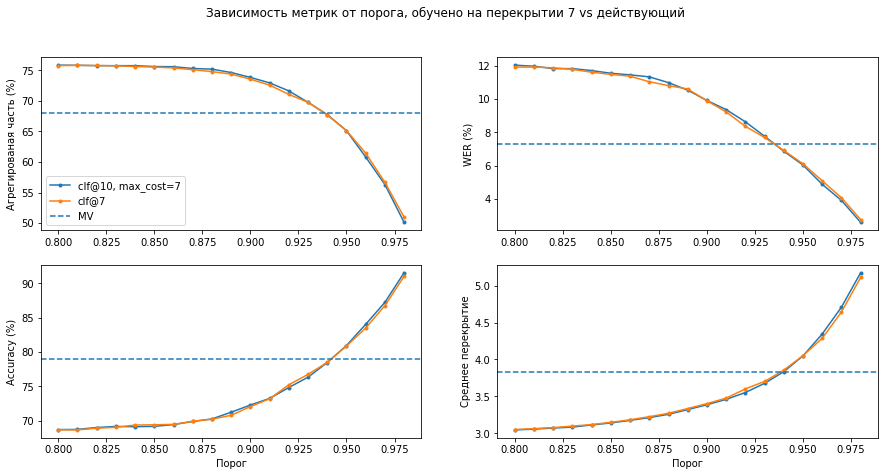

In [29]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, обучено на перекрытии 7 vs действующий')
plt.subplot(221)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 1] * 100, 
         ".-", 
         label="clf@10, max_cost=7")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 1] * 100, 
         ".-", 
         label="clf@7")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 4], 
         ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_7_vs_10_clf.png")
plt.show()

In [45]:
key = 'https://speechbase-yt.voicetech.yandex.net/getaudio/1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus'
len(test_features_q[key][1][0][''][0])

265